This project is at the intersection of `Machine Learning techniques` and `Data Analytics`, targeting on predicting the movements of `European Market Index`. Given the complex and often unpredictable nature of financial markets, traditional models have struggled to capture the full spectrum of market dynamics. This project proposes an approach by leveraging `Long Short-Term Memory (LSTM) networks`, a type of recurrent neural network that has shown exceptional promise in understanding and predicting sequences of data.

LSTMs are particularly suited for this task due to their ability to remember information over extended periods, making them ideal for the analysis of time series data, which is characteristic of stock market prices. By focusing on European Market Index, this research aims to uncover patterns and signals embedded in historical data, offering insights and predictive capabilities that can inform investment strategies and financial decision-making. This notebook serves as both a documentation of the project's methodology and a comprehensive guide for replicating the predictive analysis, illustrating the integration of cutting-edge data analytics techniques within the financial domain.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Stock Price Prediction") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/26 08:33:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/26 08:33:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/26 08:33:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Libraries

In [2]:
# Essential Libraries for Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Data Fetching and File Handling
import requests
import os
import gzip
import shutil
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import DataFrame, concat
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning Preprocessing and Metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning with Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from pmdarima import auto_arima
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter Optimization with Optuna
import optuna
from optuna.integration import KerasPruningCallback
import optuna.visualization as ov
import tensorflow as tf 

# Time Series Analysis with Statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# PySpark for Large-Scale Data Processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, trim, when, isnan, count, mean, last, first, year
from pyspark.sql.window import Window
from functools import reduce
from operator import or_

# IPython Utilities for Interactive Notebooks
from IPython.display import FileLink
import cProfile  # Import cProfile for profiling
import pstats   # Import pstats for viewing the profiling results
from statsmodels.stats.diagnostic import acorr_ljungbox

# Serialization and Model Persistence
import joblib
import copy

# Warnings and Configuration
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Diable the warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import itertools
import warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# INDEX,Rates and Technical Indicators

## INDEX Indicator

## Technical Indicators

## Technical Indicator Analysis Commentary

In the analysis of the `EURO STOXX 50` Index, It has been identified that the Financial Modeling Prep (FMP) API was not feasible for extracting technical indicators such as SMA, EMA, and MACD (5+ Year Historical Data). This led to the implementation of an alternative approach using the pandas library in Python.

The methodology adhered to established financial analysis standards and utilized conventional computational techniques for the calculation of these indicators. The `Simple Moving Average (SMA)` and the `Exponential Moving Average (EMA)` were computed over a 50-day period. Additionally, the `Moving Average Convergence Divergence (MACD)` was calculated. Initially, the MACD's three components - the MACD line, the Signal line, and the MACD Histogram - were considered. However, the analysis was later refined to include only the MACD line to maintain focus and relevance.

Utilizing pandas for this purpose offered enhanced flexibility and control in data manipulation and calculations. This approach ensured that the analysis was not constrained by the limitations of external data sources or APIs. The resulting dataset, which begins from January 2, 2006, provides a detailed view of the index's performance with accurately computed SMA, EMA, and MACD values, facilitating a thorough technical analysis.

In [4]:
# Path to the CSV file on the desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')  # Path to the desktop
file_path = os.path.join(desktop_path, 'STOXX50E.csv')  # File Name

# Load the dataset from the CSV file
index_df = pd.read_csv(file_path)

# Filter to only use 'date' and 'close' columns
index_df = index_df[['date', 'close']]

# Rename columns to 'Date' and 'Close'
index_df.rename(columns={'date': 'Date', 'close': 'Close'}, inplace=True)

# Convert 'Date' to datetime
index_df['Date'] = pd.to_datetime(index_df['Date'])

# Calculate the 50-day Simple Moving Average (SMA)
index_df['SMA'] = index_df['Close'].rolling(window=50, min_periods=1).mean()

# Calculate the 50-day Exponential Moving Average (EMA)
index_df['EMA'] = index_df['Close'].ewm(span=50, adjust=False).mean()

# Calculate only the MACD Line (12-day EMA - 26-day EMA)
index_df['MACD'] = index_df['Close'].ewm(span=12, adjust=False).mean() - index_df['Close'].ewm(span=26, adjust=False).mean()

# Filter the DataFrame for dates after 2006-01-02
index_data = index_df[index_df['Date'] >= pd.to_datetime('2006-01-02')]

# Convert 'Date' from datetime to date (to remove time component)
index_data['Date'] = index_data['Date'].dt.date

# Now, use describe() on the filtered DataFrame for the numerical columns
descriptive_stats = index_data[['Close', 'SMA', 'EMA', 'MACD']].describe()

# Print the descriptive statistics
print(descriptive_stats)

             Close          SMA          EMA         MACD
count  4580.000000  4580.000000  4580.000000  4580.000000
mean   3331.470597  3336.877300  3337.253795    -1.682844
std     608.188973   605.063876   601.451103    43.794864
min    1809.979981  2091.644585  2096.246724  -140.620963
25%    2880.682495  2880.461552  2874.442989   -28.815001
50%    3338.089966  3333.819001  3329.223542    -6.095822
75%    3740.507524  3726.657101  3703.855823    19.642689
max    4763.850100  4763.850100  4763.850100   275.182951


In [5]:
index_data.describe()

,Close,SMA,EMA,MACD
count,4580.000000,4580.000000,4580.000000,4580.000000
mean,3331.470597,3336.877300,3337.253795,-1.682844
std,608.188973,605.063876,601.451103,43.794864
min,1809.979981,2091.644585,2096.246724,-140.620963
25%,2880.682495,2880.461552,2874.442989,-28.815001
50%,3338.089966,3333.819001,3329.223542,-6.095822
75%,3740.507524,3726.657101,3703.855823,19.642689
max,4763.850100,4763.850100,4763.850100,275.182951


In [6]:
index_data.head()

,Date,Close,SMA,EMA,MACD
0,2024-02-16,4763.85010,4763.850100,4763.850100,0.000000
1,2024-02-15,4743.16992,4753.510010,4763.039113,-1.649701
2,2024-02-14,4709.22021,4738.746743,4760.928567,-5.631641
3,2024-02-13,4689.27979,4726.380005,4758.118811,-10.277905
4,2024-02-12,4746.35010,4730.374024,4757.657293,-9.248395


## Interest Rate API (Eurostat)

In [7]:
# Dataset code
dataset_code = "ei_mfir_m"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [8]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'ei_mfir_m.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 's_adj', 'p_adj', 'indic', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['indic'] == 'MF-3MI-RT')
]

# Drop unnecessary columns
structured_data.drop(['freq', 's_adj', 'p_adj'], axis=1, inplace=True)

# Filter for date range (from Jan, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_2006 = date_columns[date_columns >= '2005-01 ']
structured_data = structured_data[['indic','geo'] + list(dates_from_2006)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [9]:
# Ensure that the date columns include '2005-01'
date_columns = structured_data.columns[4:]  # Starting from the 5th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Interest')

# Ensure 'Period' is of datetime type
melted_data['Period'] = pd.to_datetime(melted_data['Period'])

# Filter for 'geo' == 'EA'
Interest_data_ea = melted_data[melted_data['geo'] == 'EA']

# Apply forward filling
Interest_data_ea = Interest_data_ea.sort_values('Period')
Interest_data_ea['Interest'] = Interest_data_ea['Interest'].ffill()

# Reset index for a clean DataFrame
Interest_data_ea.reset_index(drop=True, inplace=True)

# Display the transformed DataFrame
print(Interest_data_ea.head(10))

  geo     Period  Interest
0  EA 2005-03-01  2.13720 
1  EA 2005-04-01  2.13720 
2  EA 2005-05-01  2.12560 
3  EA 2005-06-01  2.11100 
4  EA 2005-07-01  2.11940 
5  EA 2005-08-01  2.13250 
6  EA 2005-09-01  2.13910 
7  EA 2005-10-01  2.19660 
8  EA 2005-11-01  2.36090 
9  EA 2005-12-01  2.47290 


##### Forward Filling

In [10]:
# Convert 'Period' to datetime
Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])

# Set 'Period' as the index
Interest_data_ea.set_index('Period', inplace=True)

# Create a daily date range that covers the entire period in your data
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame to this date range, forward filling the missing values
daily_interest_data = Interest_data_ea.reindex(all_days).ffill()

# Reset the index so 'Period' becomes a column again
daily_interest_data.reset_index(inplace=True)
daily_interest_data.rename(columns={'index': 'Period'}, inplace=True)

# Filter for dates starting from January 2, 2006
daily_interest_data = daily_interest_data[daily_interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_interest_data = daily_interest_data[~daily_interest_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA  2.51170 
308 2006-01-03  EA  2.51170 
309 2006-01-04  EA  2.51170 
310 2006-01-05  EA  2.51170 
311 2006-01-06  EA  2.51170 
314 2006-01-09  EA  2.51170 
315 2006-01-10  EA  2.51170 
316 2006-01-11  EA  2.51170 
317 2006-01-12  EA  2.51170 
318 2006-01-13  EA  2.51170 


##### Data Filling

In [11]:
# Check if 'Period' is in the columns; if not, the index might already be the 'Period'
if 'Period' in Interest_data_ea.columns:
    Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])
    Interest_data_ea.set_index('Period', inplace=True)
elif not isinstance(Interest_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    Interest_data_ea.index = pd.to_datetime(Interest_data_ea.index)

# Create a daily date range
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to create a DataFrame with all days, introducing NaNs for days without data
interest_data = Interest_data_ea.reindex(all_days)

# Convert the index to a numerical value for KNN
interest_data['Day_Ordinal'] = interest_data.index.map(datetime.toordinal)

# Extract the 'Interest' column for imputation
knn_data = interest_data[['Day_Ordinal', 'Interest']].values

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Put the imputed 'Interest' data back into the DataFrame
interest_data['Interest'] = knn_data_imputed[:, 1]

# Drop the 'Day_Ordinal' column as it's no longer needed
interest_data.drop('Day_Ordinal', axis=1, inplace=True)

# Reset index to make 'Period' a column again
interest_data.reset_index(inplace=True)
interest_data.rename(columns={'index': 'Period'}, inplace=True)

# If the 'geo' column is required, fill it with a constant value (e.g., 'EA')
interest_data['geo'] = 'EA'

# Filter for dates starting from January 2, 2006
interest_data = interest_data[interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
interest_data = interest_data[~interest_data['Period'].dt.dayofweek.isin([5, 6])]


# Display the first 10 rows of the daily data
print(interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA    2.5337
308 2006-01-03  EA    2.5337
309 2006-01-04  EA    2.5337
310 2006-01-05  EA    2.5337
311 2006-01-06  EA    2.5337
314 2006-01-09  EA    2.5337
315 2006-01-10  EA    2.5337
316 2006-01-11  EA    2.5337
317 2006-01-12  EA    2.5337
318 2006-01-13  EA    2.5337


In [12]:
# Check for null values
null_counts = interest_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = interest_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (interest_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (interest_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

NaN Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

Zero Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

N/A Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64


## Bonds Yields API (Eurostat)

In [13]:
# Dataset code
dataset_code = "irt_euryld_d"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [14]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'irt_euryld_d.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'yld_curv', 'maturity', 'bonds', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['yld_curv'] == 'SPOT_RT') & 
    (structured_data['bonds'] == 'CGB_EA')
]

# Drop unnecessary columns
structured_data.drop(['freq', 'geo'], axis=1, inplace=True)

# Filter for date range (from January 2, 2006, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2006-01-02 ']
structured_data = structured_data[['yld_curv', 'maturity', 'bonds'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [15]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Assuming date columns start from the 4th column
data_for_melting = structured_data[['maturity'] + list(date_columns)]

# Melt the DataFrame to change its structure
bonds_data = pd.melt(data_for_melting, id_vars=['maturity'], var_name='Period', value_name='Rate')

# Specify the desired maturities (M3 to M11 and Y1 to Y30)
desired_maturities = [f'M{i}' for i in range(0, 13)] + [f'Y{i}' for i in range(1, 31)]

# Filter the DataFrame to include only the specified maturities
bonds_data = bonds_data[bonds_data['maturity'].isin(desired_maturities)]

# Rearrange the columns
bonds_data = bonds_data[['Period', 'maturity', 'Rate']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(bonds_data.head())


        Period maturity     Rate
0  2006-01-02       M10  2.63864
1  2006-01-02       M11   2.6671
2  2006-01-02        M3  2.34702
3  2006-01-02        M4  2.40081
4  2006-01-02        M5  2.44996


In [16]:
# Check for null values
null_counts = bonds_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = bonds_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (bonds_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (bonds_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

NaN Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

Zero Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

N/A Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64


## Inflation Rate API (Eurostat)

In [17]:
# Dataset code
dataset_code = "prc_hicp_manr"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [18]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'prc_hicp_manr.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'unit', 'coicop', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['unit'] == 'RCH_A') & 
    (structured_data['coicop'] == 'CP00')
]

# Drop unnecessary columns
structured_data.drop(['freq'], axis=1, inplace=True)

# Filter for date range (from January 1, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2005-01']
structured_data = structured_data[['unit', 'coicop', 'geo'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [19]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Include all date columns starting from the 4th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Inflation')

# Filter for 'geo' == 'EA' and convert 'Period' to datetime format
inflation_data_ea = melted_data[melted_data['geo'] == 'EA']
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Ensure the DataFrame is sorted by period and forward fill missing 'Inflation' values
inflation_data_ea = inflation_data_ea.sort_values(by='Period')
inflation_data_ea['Inflation'] = inflation_data_ea.groupby('geo')['Inflation'].ffill()

# Reset the index and display the DataFrame
inflation_data_ea = inflation_data_ea.reset_index(drop=True)
print(inflation_data_ea.head(10))

  geo     Period Inflation
0  EA 2005-01-01      1.9 
1  EA 2005-02-01      2.1 
2  EA 2005-03-01      2.2 
3  EA 2005-04-01      2.1 
4  EA 2005-05-01      2.0 
5  EA 2005-06-01      2.0 
6  EA 2005-07-01      2.1 
7  EA 2005-08-01      2.2 
8  EA 2005-09-01      2.6 
9  EA 2005-10-01      2.5 


##### Forward Filling

In [20]:
# Convert 'Period' to datetime
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Set 'Period' as the DataFrame index
inflation_data_ea.set_index('Period', inplace=True)

# Resample to daily data using forward fill
daily_data_ffill = inflation_data_ea.resample('D').ffill()

# Reset index to move 'Period' back to a column
daily_data_ffill.reset_index(inplace=True)

# Filter for dates starting from January 2, 2006
daily_data_ffill = daily_data_ffill[daily_data_ffill['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_data_ffill = daily_data_ffill[~daily_data_ffill['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_data_ffill.head(10))

        Period geo Inflation
366 2006-01-02  EA      2.4 
367 2006-01-03  EA      2.4 
368 2006-01-04  EA      2.4 
369 2006-01-05  EA      2.4 
370 2006-01-06  EA      2.4 
373 2006-01-09  EA      2.4 
374 2006-01-10  EA      2.4 
375 2006-01-11  EA      2.4 
376 2006-01-12  EA      2.4 
377 2006-01-13  EA      2.4 


##### Data Filling

In [21]:
# Check if 'Period' is in the columns; if not, the index should already be the 'Period'
if 'Period' in inflation_data_ea.columns:
    inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])
    inflation_data_ea.set_index('Period', inplace=True)
elif not isinstance(inflation_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    inflation_data_ea.index = pd.to_datetime(inflation_data_ea.index)

# Convert non-numeric values to NaN in the 'Inflation' column
inflation_data_ea['Inflation'] = pd.to_numeric(inflation_data_ea['Inflation'], errors='coerce')

# Create a daily date range that covers the entire period of your data
date_range = pd.date_range(start=inflation_data_ea.index.min(), end=inflation_data_ea.index.max(), freq='D')

# Create a new DataFrame for KNN imputation
inflation_data = pd.DataFrame(date_range, columns=['Period'])

# Merge with your existing data - this will introduce NaNs for days without data
inflation_data = inflation_data.merge(inflation_data_ea, how='left', left_on='Period', right_index=True)

# Convert 'Period' to a numerical value (e.g., days since start)
min_date = inflation_data['Period'].min()
inflation_data['Day_Ordinal'] = (inflation_data['Period'] - min_date).dt.days

# Prepare data for KNN imputation
knn_data = inflation_data[['Day_Ordinal', 'Inflation']]

# Initialize KNN Imputer - 5 neighbors / Week
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Add imputed data back to DataFrame
inflation_data['Inflation'] = knn_data_imputed[:, 1]

# Fill 'geo' column with 'EA'
inflation_data['geo'] = 'EA'

# Convert 'Day_Ordinal' back to datetime
inflation_data['Period'] = inflation_data['Day_Ordinal'].apply(lambda x: min_date + timedelta(days=x))

# Drop the 'Day_Ordinal' column
inflation_data.drop(columns='Day_Ordinal', inplace=True)

# Filter for dates starting from January 2, 2006
inflation_data = inflation_data[inflation_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
inflation_data = inflation_data[~inflation_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(inflation_data.head(10))

        Period geo  Inflation
366 2006-01-02  EA       2.32
367 2006-01-03  EA       2.32
368 2006-01-04  EA       2.32
369 2006-01-05  EA       2.32
370 2006-01-06  EA       2.32
373 2006-01-09  EA       2.32
374 2006-01-10  EA       2.32
375 2006-01-11  EA       2.32
376 2006-01-12  EA       2.32
377 2006-01-13  EA       2.32


In [22]:
# Check for null values
null_counts = inflation_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = inflation_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (inflation_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (inflation_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)


Null Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

NaN Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

Zero Values in Each Column:
 Period       0
geo          0
Inflation    3
dtype: int64

N/A Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64


# SparkSQL: Tables Connection

In [23]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Stock Market Trends Analysis") \
    .getOrCreate()

# Function to format date columns in Pandas DataFrame
def format_date_columns(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column]).dt.date
    return df

# Format date columns
index_data = format_date_columns(index_data, 'Date')
interest_data = format_date_columns(interest_data, 'Period')
bonds_data = format_date_columns(bonds_data, 'Period')
inflation_data = format_date_columns(inflation_data, 'Period')

# Convert Pandas DataFrame to Spark DataFrame
index_df_spark = spark.createDataFrame(index_data)
interest_df_spark = spark.createDataFrame(interest_data)
bonds_df_spark = spark.createDataFrame(bonds_data)
inflation_df_spark = spark.createDataFrame(inflation_data)

# Trim and convert date columns to DateType
index_df_spark = index_df_spark.withColumn("Date", to_date(trim(col("Date")), "yyyy-MM-dd"))
interest_df_spark = interest_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
bonds_df_spark = bonds_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
inflation_df_spark = inflation_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))

# Create Temporary Views
index_df_spark.createOrReplaceTempView("indexView")
interest_df_spark.createOrReplaceTempView("interestView")
bonds_df_spark.createOrReplaceTempView("bondsView")
inflation_df_spark.createOrReplaceTempView("inflationView")

# Pivot and process bonds data to have maturity rates as separate columns
bonds_df_pivoted = bonds_df_spark.groupBy("Period").pivot("maturity").agg(first("Rate"))
bonds_df_pivoted.createOrReplaceTempView("bondsPivotedView")

# SQL Query for Joining
join_query = """
SELECT i.Date, i.Close, i.MACD, i.SMA, i.EMA,
       int.Interest as InterestRate, 
       inf.Inflation as InflationRate,
       b.M3, b.M6, b.M9, b.Y1, b.Y3, b.Y5, b.Y10, b.Y20, b.Y30
FROM indexView i
LEFT JOIN interestView int ON i.Date = int.Period
LEFT JOIN bondsPivotedView b ON i.Date = b.Period
LEFT JOIN inflationView inf ON i.Date = inf.Period
"""

# Execute the query and show the Result
dataset = spark.sql(join_query)
dataset.show(10)

24/09/26 08:33:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/09/26 08:33:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|     Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2024-02-05|4655.27002| -21.39123992203531|       4710.351027|4745.2460523204845|3.9180800000000007|              2.62|3.88726| 3.6421|3.43694|3.26609|2.66683|2.66288|3.01592| 3.3946|3.46675|
|2024-02-16| 4763.8501|                0.0|         4763.8501|         4763.8501|            3.8942|2.5599999999999996|3.89213|3.69046|3.51988|3.37617|2.84118|2.80438|3.07186|3.39073|3.44119|
|2024-02-09|4715.87012|-10.7678564033922

In [24]:
# DataFrame: joined_df
numeric_column_types = ['int', 'double', 'float', 'long']

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = joined_df.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A' # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count() # Check only for nulls in non-numeric columns

    print(f"Column '{column}': Zeros = {zero_count}, Nulls or NaNs = {null_or_nan_count}")

Column 'Date': Zeros = N/A, Nulls or NaNs = 0


Column 'Close': Zeros = N/A, Nulls or NaNs = 0
Column 'MACD': Zeros = N/A, Nulls or NaNs = 0
Column 'SMA': Zeros = N/A, Nulls or NaNs = 0
Column 'EMA': Zeros = N/A, Nulls or NaNs = 0
Column 'InterestRate': Zeros = N/A, Nulls or NaNs = 0


Column 'InflationRate': Zeros = N/A, Nulls or NaNs = 0


Column 'M3': Zeros = N/A, Nulls or NaNs = 15


Column 'M6': Zeros = N/A, Nulls or NaNs = 15
Column 'M9': Zeros = N/A, Nulls or NaNs = 15


Column 'Y1': Zeros = N/A, Nulls or NaNs = 15


Column 'Y3': Zeros = N/A, Nulls or NaNs = 15


Column 'Y5': Zeros = N/A, Nulls or NaNs = 15


Column 'Y10': Zeros = N/A, Nulls or NaNs = 15


Column 'Y20': Zeros = N/A, Nulls or NaNs = 15


Column 'Y30': Zeros = N/A, Nulls or NaNs = 15


In [25]:
# DataFrame: dataset
numeric_column_types = ['int', 'double', 'float', 'long']

# Initialize an empty dictionary to store columns with non-zero null, NaN, or N/A counts
columns_with_missing_values = {}

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = dataset.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A'  # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count()  # Check only for nulls in non-numeric columns

    # Add to dictionary if there are non-zero nulls, NaNs, or zeros for numeric columns
    if zero_count != 'N/A':
        if null_or_nan_count > 0 or zero_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}
    else:
        if null_or_nan_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}

# Display columns with missing values
for column, counts in columns_with_missing_values.items():
    print(f"Column '{column}': Zeros = {counts['Zeros']}, Nulls or NaNs = {counts['Nulls_or_NaNs']}")

Column 'M3': Zeros = N/A, Nulls or NaNs = 15
Column 'M6': Zeros = N/A, Nulls or NaNs = 15
Column 'M9': Zeros = N/A, Nulls or NaNs = 15
Column 'Y1': Zeros = N/A, Nulls or NaNs = 15
Column 'Y3': Zeros = N/A, Nulls or NaNs = 15
Column 'Y5': Zeros = N/A, Nulls or NaNs = 15
Column 'Y10': Zeros = N/A, Nulls or NaNs = 15
Column 'Y20': Zeros = N/A, Nulls or NaNs = 15
Column 'Y30': Zeros = N/A, Nulls or NaNs = 15


In [26]:
from pyspark.sql.functions import col, isnan

# Function to create a column condition for checking if a column is null or NaN
def is_missing(column_name):
    return col(column_name).isNull() | isnan(col(column_name))

# Create a combined condition for all bond rate columns
bond_rate_conditions = is_missing('M3') | is_missing('M6') | is_missing('M9') | \
                       is_missing('Y1') | is_missing('Y3') | is_missing('Y5') | \
                       is_missing('Y10') | is_missing('Y20') | is_missing('Y30')

# Count the total number of rows
total_rows = dataset.count()

# Count rows where any one of the specific columns is missing
missing_columns_count = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
).count()

# Calculate the percentage of such instances
percentage_missing_columns = (missing_columns_count / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing rates: {missing_columns_count}")
print(f"Percentage of Rows with missing any rate: {percentage_missing_columns:.2f}%")

# Filter the DataFrame to get rows with missing values in specific columns
missing_values_table = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
)

# Show the rows with missing values
missing_values_table.show()

Total Rows: 4580
Rows with 'Close' but missing rates: 15
Percentage of Rows with missing any rate: 0.33%


+----------+------------+-------------------+------------------+------------------+--------------------+------------------+----+----+----+----+----+----+----+----+----+
|      Date|       Close|               MACD|               SMA|               EMA|        InterestRate|     InflationRate|  M3|  M6|  M9|  Y1|  Y3|  Y5| Y10| Y20| Y30|
+----------+------------+-------------------+------------------+------------------+--------------------+------------------+----+----+----+----+----+----+----+----+----+
|2022-06-22|3464.6398926|-28.238746293933218|3601.7518102999998| 3549.685222696644|             0.16346|              8.92|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|2020-12-24| 3543.280029| -20.92007916041166|3630.2670117280004|3650.4786437896482| -0.5372800000000001|               0.5|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|2023-04-06|     4309.45| 3.2365688713516647|     4334.42198324|   4341.3527303211|             3.12404|               6.8|NULL|NULL|NULL|NULL|NULL|NULL|NU

## Data Approuch

In [27]:
# 'Date' column can be used for partitioning
window_spec_forward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
window_spec_backward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.currentRow, Window.unboundedFollowing)

# List of all columns to be filled
columns_to_fill = ['InterestRate', 'InflationRate'] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Apply forward fill followed by backward fill for each column
for col_name in columns_to_fill:
    dataset_ff = dataset.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_forward))
    dataset_ff = dataset_ff.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_backward))

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [28]:
# Create a combined condition for all bond rate columns
bond_rate_conditions = (
    col("M3").isNull() | isnan(col("M3")) |
    col("M6").isNull() | isnan(col("M6")) |
    col("M9").isNull() | isnan(col("M9")) |
    col("Y1").isNull() | isnan(col("Y1")) |
    col("Y3").isNull() | isnan(col("Y3")) |
    col("Y5").isNull() | isnan(col("Y5")) |
    col("Y10").isNull() | isnan(col("Y10")) |
    col("Y20").isNull() | isnan(col("Y20")) |
    col("Y30").isNull() | isnan(col("Y30"))
)

# Count rows where 'Close' is available but any one of 'InterestRate', bond rate columns, or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        bond_rate_conditions |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 15
Percentage of Rows with missing any one rate: 0.33%


#### MEAN to fill the Missing Day Value

In [29]:
# Define the numeric columns for interest rate, inflation rate, and bond rates
numeric_cols = ["InterestRate", "InflationRate"] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Calculate the mean of non-null values for each column
mean_values = dataset_ff.select([mean(c).alias(c) for c in numeric_cols]).collect()[0].asDict()

# Fill null values with the mean for each column
for col in numeric_cols:
    dataset_ff = dataset_ff.na.fill({col: mean_values[col]})

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [30]:
from pyspark.sql.functions import col, isnan
from functools import reduce
from pyspark.sql import functions as F

# Define the bond rate columns
bond_rate_cols = ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Create a combined condition to check for missing values in bond rate columns
bond_rate_missing_condition = [col(c).isNull() | isnan(col(c)) for c in bond_rate_cols]

# Combine all conditions using a logical OR
combined_bond_rate_condition = reduce(lambda x, y: x | y, bond_rate_missing_condition)

# Count the total number of rows
total_rows = dataset_ff.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        combined_bond_rate_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


In [31]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_pd = dataset.toPandas()

# Define the list of numeric columns including interest rate, inflation rate, and bond rate columns
numeric_cols = ["InterestRate", "InflationRate", "M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Replace non-numeric values to NaN
dataset_pd[numeric_cols] = dataset_pd[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
dataset_pd[numeric_cols] = knn_imputer.fit_transform(dataset_pd[numeric_cols])

# Convert back to Spark DataFrame
dataset_knn = spark.createDataFrame(dataset_pd)

In [32]:
# Sort the DataFrame in ascending order by the 'date' column
dataset_knn = dataset_knn.orderBy("Date")

# Show the result
dataset_knn.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|3.87534|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|3.86669|
|2006-01-04|3652.459961|-11.4738414

In [33]:
# Define all Bond Rate columns
bond_rate_columns = ["M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Create a condition to check for missing values in any bond rate column
bond_rate_missing_condition = reduce(or_, [col(name).isNull() | isnan(col(name)) for name in bond_rate_columns])

# Count the total number of rows
total_rows = dataset_knn.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_knn.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        bond_rate_missing_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


# ARIMA - AUTOARIMA - LSTM / Model

## 1- Load and Structure the Data

In [34]:
# Dataset_knn is a Spark DataFrame, converting to Pandas DataFrame
dataset_knn_pandas = dataset_knn.toPandas()

# Sort the DataFrame in ascending order by the 'Date' column
dataset_knn_pandas = dataset_knn_pandas.sort_values(by='Date')

# Ensure the 'Date' column is datetime
dataset_knn_pandas['Date'] = pd.to_datetime(dataset_knn_pandas['Date'])

# 'Close' is a float and drop NaN values
dataset_knn_pandas['Close'] = dataset_knn_pandas['Close'].astype(float)
dataset_knn_pandas.dropna(subset=['Close'], inplace=True)

In [35]:
# Convert the 'Date' column to date format
dataset_knn = dataset_knn.withColumn('Date', to_date(col('Date')))

# Define the start and end dates for the date range
start_date = '2007-01-02'
end_date = '2024-02-13'

# Filter the dataset to include only rows within the specified date range
dataset_knn = dataset_knn.filter((col('Date') >= start_date) & (col('Date') <= end_date))

# Drop rows with any NaN values
dataset_knn = dataset_knn.na.drop()

# Show the max and min dates in the capped dataset to verify
min_date = dataset_knn.agg({"Date": "min"}).collect()[0][0]
max_date = dataset_knn.agg({"Date": "max"}).collect()[0][0]
print(f"Data capped from: {min_date} to {max_date}")

# Display the first 10 rows to verify the dataset
dataset_knn.show(10)

Data capped from: 2007-01-03 to 2024-02-13
+----------+-----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2007-01-03|4188.240234| -8.511311695257973|     4164.90419922| 4181.063391854702|     3.74848|1.8400000000000003|3.47207|3.61962|3.70464| 3.7528|3.80392|3.82737|3.95271|4.10548|4.16607|
|2007-01-04|4177.759766| -12.39892159014562|     4159.26239258|  4180.77045952224|     3.74848|1.8400000000000003|3.48645|3.63042|3.71342|3.76039|3.81012|3.83536|3.96503|4.12047|4.18173|
|2007-01-05|4129.35009

In [36]:
print(dataset_knn_pandas.index)

RangeIndex(start=0, stop=4580, step=1)


In [37]:
print(dataset_knn_pandas.columns)

Index(['Date', 'Close', 'MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
       'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30'],
      dtype='object')


## 2- Stationarize the Data (For ARIMA)

### 2.1- Analyze if the Dataset is Stationary

In [38]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pandas = dataset_knn.toPandas()

# 'Close' is a float and drop NaN values
dataset_knn_pandas['Close'] = dataset_knn_pandas['Close'].astype(float)
dataset_knn_pandas.dropna(subset=['Close'], inplace=True)

# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1]  # Return the p-value

# Perform ADF test on the Close price
p_value = adf_test(dataset_knn_pandas['Close'])

if p_value > 0.05:
    print("The data is non-stationary.")
else:
    print("The data is stationary.")

ADF Statistic: -1.8153931481900316
p-value: 0.37284664524104116
Critical Values:
   1%: -3.431866031861332
   5%: -2.862209898783688
   10%: -2.5671265919448807
The data is non-stationary.


### 2.2 Turn the Data Stationary

In [39]:
# Differencing to make data stationary
differencing_order = 0
while p_value > 0.05:
    differencing_order += 1
    dataset_knn_pandas['Close_diff'] = dataset_knn_pandas['Close'].diff(differencing_order).dropna()
    p_value = adf_test(dataset_knn_pandas['Close_diff'])

print(f'Data is stationary after {differencing_order} differencing(s)')

ADF Statistic: -28.101396713283357
p-value: 0.0
Critical Values:
   1%: -3.4318667351229823
   5%: -2.8622102094592465
   10%: -2.5671267573332957
Data is stationary after 1 differencing(s)


### 2.2 Recheck ADF after Differencing

In [40]:
# Recheck ADF after differencing
p_value_diff = adf_test(dataset_knn_pandas['Close_diff'])
if p_value_diff > 0.05:
    print("The differenced data is still non-stationary.")
else:
    print("The differenced data is now stationary.")

ADF Statistic: -28.101396713283357
p-value: 0.0
Critical Values:
   1%: -3.4318667351229823
   5%: -2.8622102094592465
   10%: -2.5671267573332957
The differenced data is now stationary.


### 2.3 Plot Non-Stationary and Stationary Data

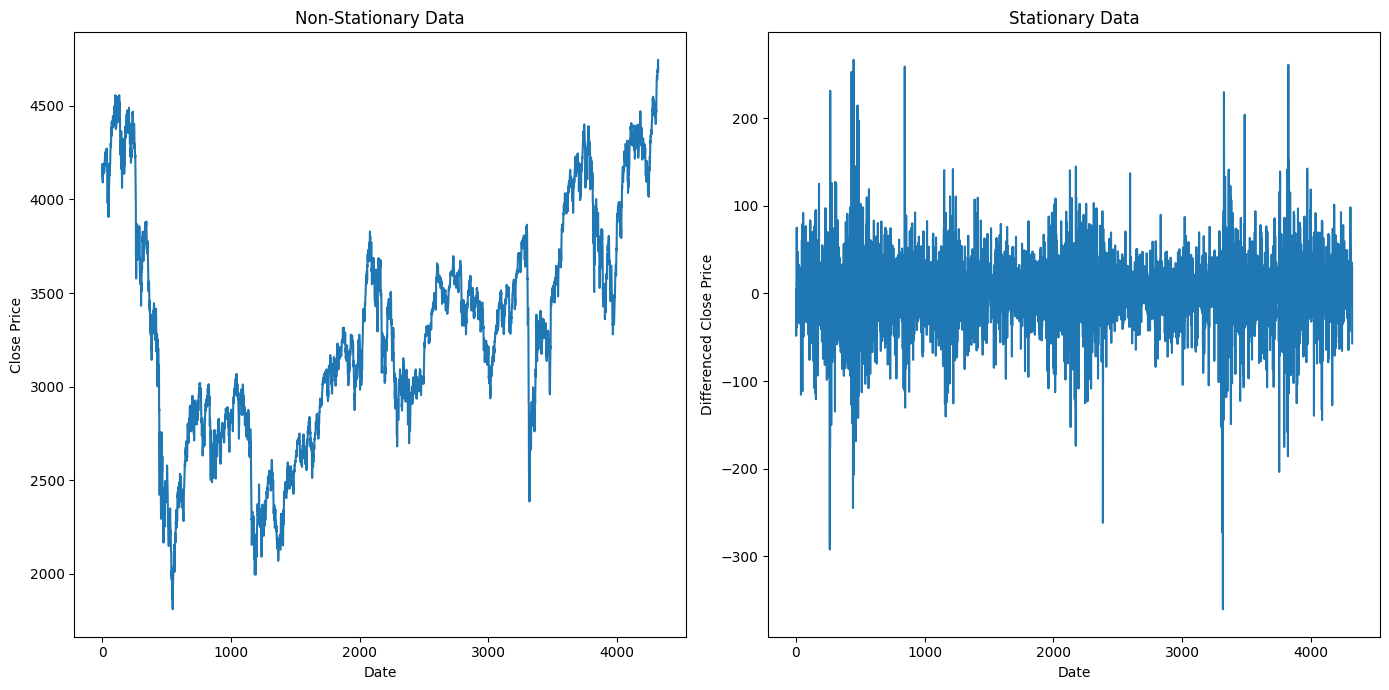

In [41]:
# Plot non-stationary data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(dataset_knn_pandas['Close'])
plt.title('Non-Stationary Data')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Plot stationary data
plt.subplot(1, 2, 2)
plt.plot(dataset_knn_pandas['Close_diff'].dropna())
plt.title('Stationary Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')

plt.tight_layout()
plt.show()

### 2.4 Partial Autocorrelation (PACF) and Autocorrelation (ACF)

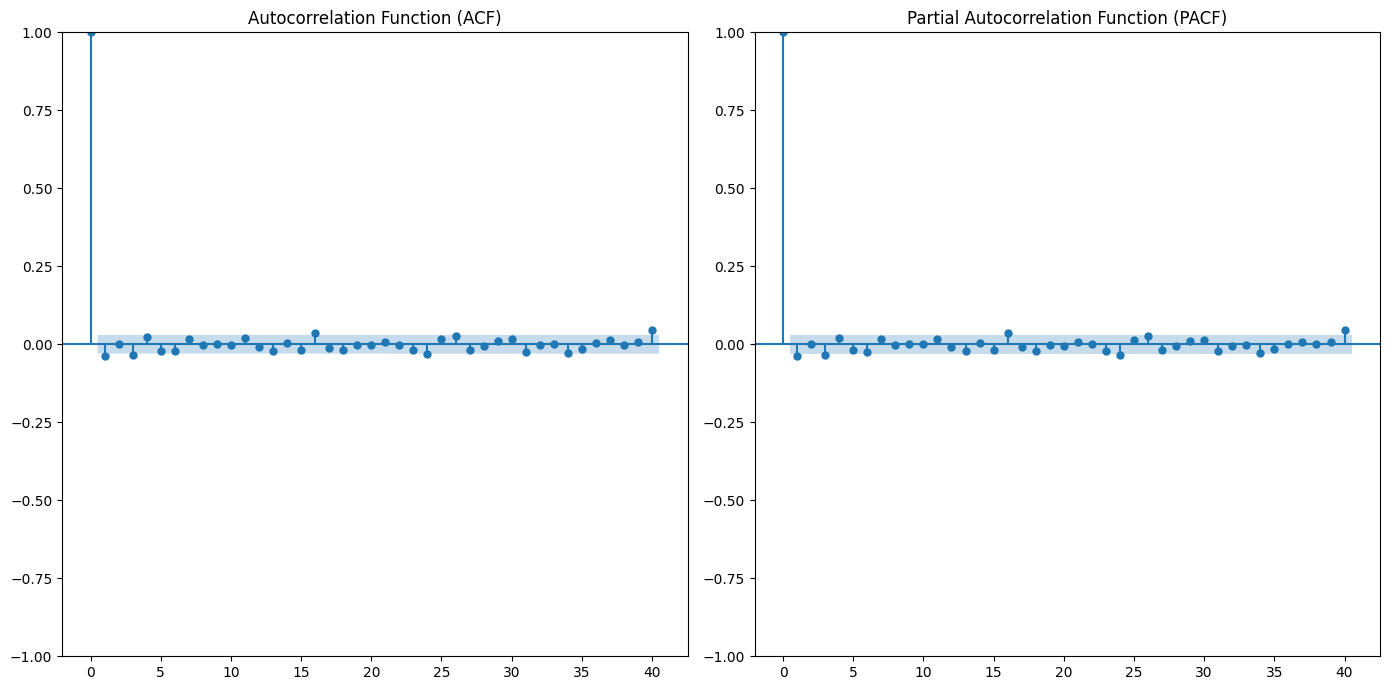

In [42]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plot_acf(dataset_knn_pandas['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(dataset_knn_pandas['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [43]:
print(dataset_knn_pandas.columns)

Index(['Date', 'Close', 'MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
       'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30', 'Close_diff'],
      dtype='object')


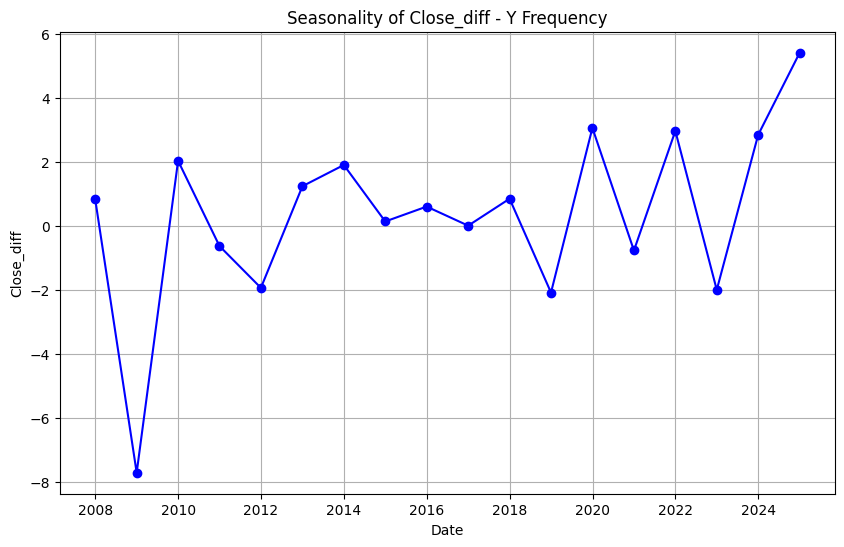

In [44]:
# 'Date' is set as index
if 'Date' in dataset_knn_pandas.columns:
    dataset_knn_pandas['Date'] = pd.to_datetime(dataset_knn_pandas['Date'])
    dataset_knn_pandas.set_index('Date', inplace=True)
else:
    dataset_knn_pandas.index = pd.to_datetime(dataset_knn_pandas.index)

# Resample the data to the yearly frequency to observe seasonality
def plot_seasonality(data, value_col, freq='Y'):
    data_resampled = data[value_col].resample(freq).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_resampled, marker='o', linestyle='-', color='b')
    plt.title(f'Seasonality of {value_col} - {freq} Frequency')
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.show()

# Example
plot_seasonality(dataset_knn_pandas, 'Close_diff', freq='Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          t-1       t+1
t-1  1.000000  0.017794
t+1  0.017794  1.000000


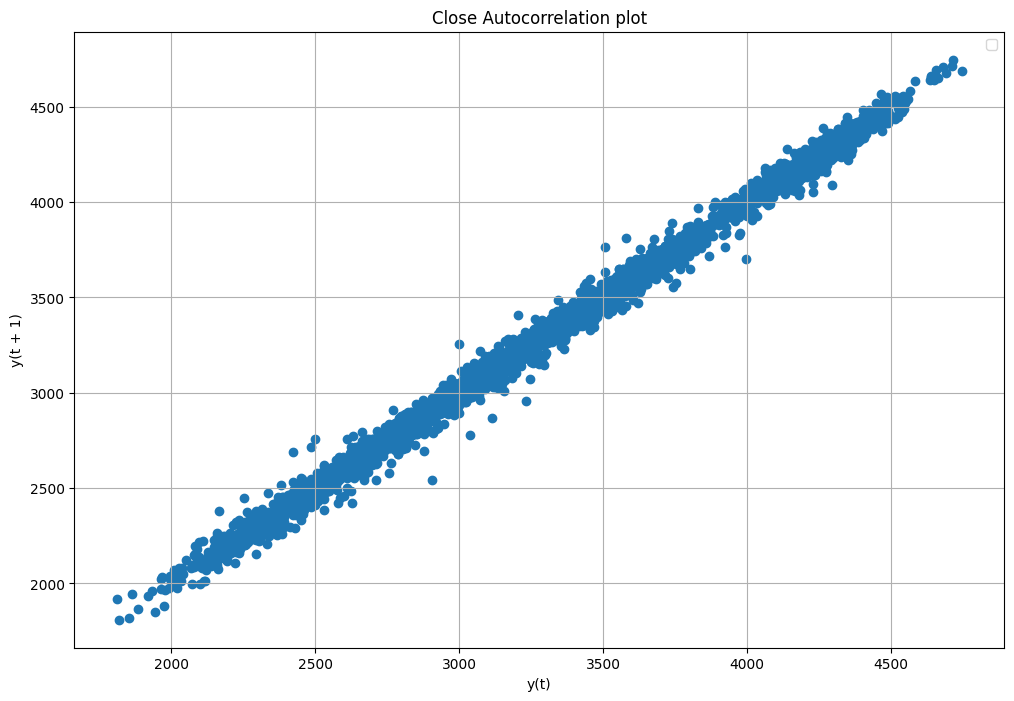

In [45]:
plt.figure(figsize=(12,8))
lag_plot(dataset_knn_pandas['Close'], lag=1)
plt.title('Close Autocorrelation plot')
plt.grid(True)
plt.legend();


values = DataFrame(dataset_knn_pandas['Close_diff'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [46]:
# Save the dataset to a CSV file
dataset_knn_pandas.to_csv('dataset_knn_pandas.csv')

# Save the dataset to a pickle file
dataset_knn_pandas.to_pickle('dataset_knn_pandas.pkl')

In [47]:
# Create a download link for the CSV file
FileLink('dataset_knn_pandas.csv')

# Create a download link for the Pickle file
FileLink('dataset_knn_pandas.pkl')

/home/fabiopoli/Desktop/dataset_knn_pandas.pkl

## 3- Build and Evaluate ARIMA Models

### 3.1 ARIMA

In [48]:
# Endogenous variable (target variable)
endog = dataset_knn_pandas['Close']

#### Determine the Differencing Order (d)

In [49]:
def determine_differencing_order(series, max_d=2):
    for d in range(max_d+1):
        diff_series = series.diff(d).dropna() if d > 0 else series
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]
        print(f'Differencing order {d}, p-value: {p_value}')
        if p_value < 0.05:
            print(f"Series is stationary with differencing order {d}")
            return d
    print(f"Series is non-stationary up to differencing order {max_d}")
    return None

In [50]:
d = determine_differencing_order(endog)

Differencing order 0, p-value: 0.37284664524104116
Differencing order 1, p-value: 0.0
Series is stationary with differencing order 1


#### Split the Data into Training and Testing Sets

In [51]:
# Define the train/test split
split_point = int(len(endog) * 0.8)
train_endog = endog.iloc[:split_point]
test_endog = endog.iloc[split_point:]

#### Define the Evaluation Function

In [52]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    # Avoid division by zero
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

In [53]:
def evaluate_arima_model(train, test, arima_order, forecast_horizon=5, save_model=False):
    history = train.tolist()
    predictions = []
    for t in range(0, len(test), forecast_horizon):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        steps = min(forecast_horizon, len(test)-t)
        yhat = model_fit.forecast(steps=steps)
        predictions.extend(yhat)
        history.extend(test.iloc[t:t+steps].tolist())
    
    # Truncate predictions to match the test size
    predictions = predictions[:len(test)]
    
    # Calculate metrics
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)
    mape = calculate_mape(test, predictions)
    
    # Save the model
    if save_model:
        model_filename = f'arima_model_order_{arima_order}.pkl'
        joblib.dump(model_fit, model_filename)
        print(f"Model saved as '{model_filename}'")
    
    return rmse, r2, mape

#### Evaluate Selected ARIMA Orders

In [54]:
selected_orders = [
    (1, d, 0),
    (1, d, 1),
    (2, d, 2),
    (3, d, 1),
    (2, d, 3)
]

In [55]:
results = []
for order in selected_orders:
    rmse, r2, mape = evaluate_arima_model(train_endog, test_endog, order, forecast_horizon=5, save_model=True)
    results.append({'ARIMA_Order': order, 'RMSE': rmse, 'R2': r2, 'MAPE': mape})
    print(f'ARIMA{order} - RMSE: {rmse}, R2: {r2}, MAPE: {mape}')


Model saved as 'arima_model_order_(1, 1, 0).pkl'
ARIMA(1, 1, 0) - RMSE: 68.79984091273462, R2: 0.9611302482268014, MAPE: 1.2767632989845894
Model saved as 'arima_model_order_(1, 1, 1).pkl'
ARIMA(1, 1, 1) - RMSE: 68.98456326191565, R2: 0.9609212433572598, MAPE: 1.2808510181089152
Model saved as 'arima_model_order_(2, 1, 2).pkl'
ARIMA(2, 1, 2) - RMSE: 68.96407634285772, R2: 0.9609444509969247, MAPE: 1.2819827605416574
Model saved as 'arima_model_order_(3, 1, 1).pkl'
ARIMA(3, 1, 1) - RMSE: 68.7783362478453, R2: 0.9611545433513272, MAPE: 1.2764790541440891
Model saved as 'arima_model_order_(2, 1, 3).pkl'
ARIMA(2, 1, 3) - RMSE: 68.87721311213092, R2: 0.9610427733365973, MAPE: 1.2790233373325939


In [56]:
# Display the results
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\nTop models based on RMSE, R2, and MAPE:")
print(results_df)

# Save the results to a CSV file for later reference
results_df.to_csv('arima_model_evaluation_results.csv', index=False)
print("Results saved to 'arima_model_evaluation_results.csv'")


Top models based on RMSE, R2, and MAPE:
  ARIMA_Order       RMSE        R2      MAPE
3   (3, 1, 1)  68.778336  0.961155  1.276479
0   (1, 1, 0)  68.799841  0.961130  1.276763
4   (2, 1, 3)  68.877213  0.961043  1.279023
2   (2, 1, 2)  68.964076  0.960944  1.281983
1   (1, 1, 1)  68.984563  0.960921  1.280851
Results saved to 'arima_model_evaluation_results.csv'


### ARIMA Best Model (3,1,1) Code

In [57]:
# Load the ARIMA model (3, 1, 1)
model_filename = 'arima_model_order_(3, 1, 1).pkl'
model_fit = joblib.load(model_filename)
print(f"Loaded model from '{model_filename}'")

Loaded model from 'arima_model_order_(3, 1, 1).pkl'


#### Generate Predictions on the Test Set

In [58]:
# Rebuild the history to include only the training data
history = train_endog.tolist()
predictions = []

In [59]:
for t in range(len(test_endog)):
    model = ARIMA(history, order=(3, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_endog.iloc[t])

In [60]:
# Create a series for the predicted values with the same index as the test data
predicted_series = pd.Series(predictions, index=test_endog.index)

#### Plot Actual vs. Predicted Values

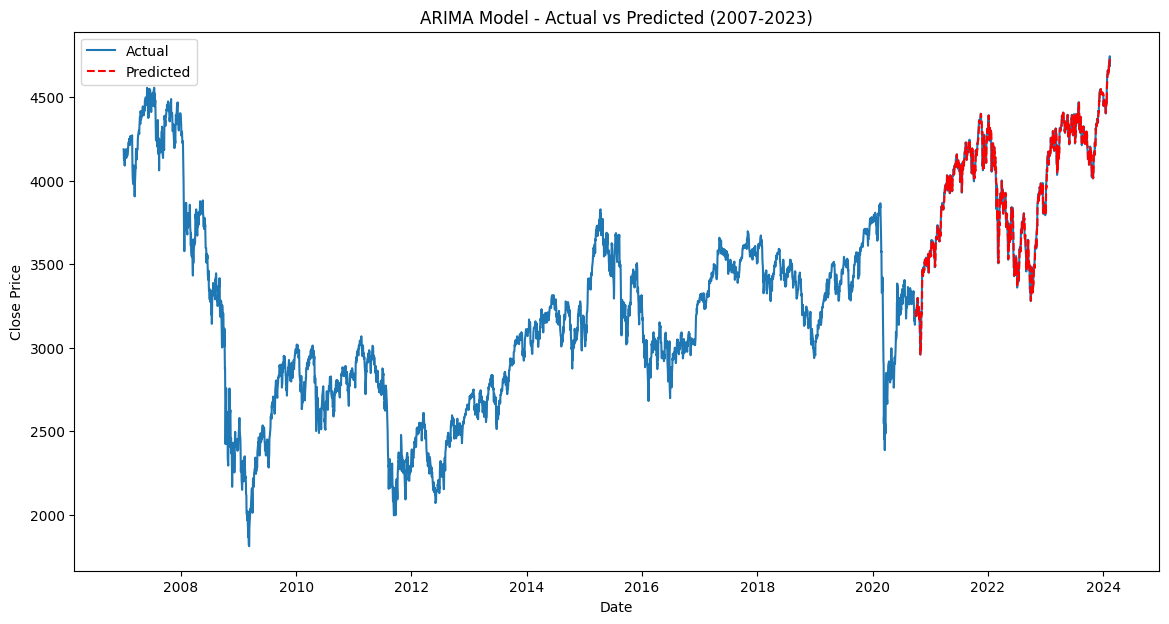

In [61]:
plt.figure(figsize=(14, 7))
plt.plot(endog, label='Actual')
plt.plot(predicted_series, label='Predicted', color='red', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted (2007-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

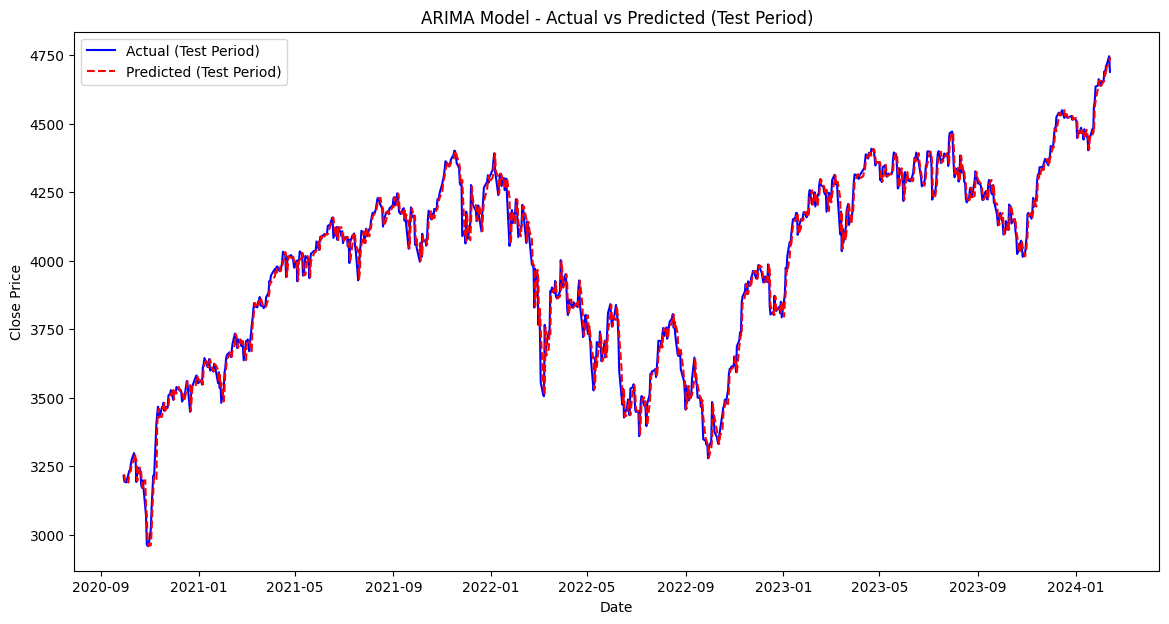

In [62]:
plt.figure(figsize=(14, 7))
plt.plot(test_endog.index, test_endog, label='Actual (Test Period)', color='blue')
plt.plot(predicted_series.index, predicted_series, label='Predicted (Test Period)', color='red', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [63]:
# Calculate and display evaluation metrics for the predictions
rmse = sqrt(mean_squared_error(test_endog, predicted_series))
r2 = r2_score(test_endog, predicted_series)
mape = calculate_mape(test_endog, predicted_series)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}%")

RMSE: 43.63673308946214
R^2 Score: 0.9843634348891849
MAPE: 0.8037171505434048%


### Check for Multicollinearity

In [64]:
# Exogenous variables
exog = dataset_knn_pandas[['InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30', 'MACD', 'SMA', 'EMA']]

# Scale exogenous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
exog_scaled = pd.DataFrame(scaler.fit_transform(exog), index=exog.index, columns=exog.columns)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = exog_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(exog_scaled.values, i) for i in range(len(exog_scaled.columns))]

print(vif_data)

          feature           VIF
0    InterestRate  7.330210e+01
1   InflationRate  2.548589e+00
2              M3  6.764009e+04
3              M6  2.038510e+06
4              M9  6.480182e+06
5              Y1  2.221419e+06
6              Y3  5.345508e+04
7              Y5  2.916582e+04
8             Y10  7.920344e+03
9             Y20  3.248547e+03
10            Y30  4.676130e+02
11           MACD  2.339616e+00
12            SMA  6.136784e+02
13            EMA  6.220124e+02


In [65]:
mean_close = endog.mean()
min_close = endog.min()
max_close = endog.max()

print(f"Mean Close Price: {mean_close}")
print(f"Minimum Close Price: {min_close}")
print(f"Maximum Close Price: {max_close}")

Mean Close Price: 3303.1300466636426
Minimum Close Price: 1809.9799805
Maximum Close Price: 4746.3501


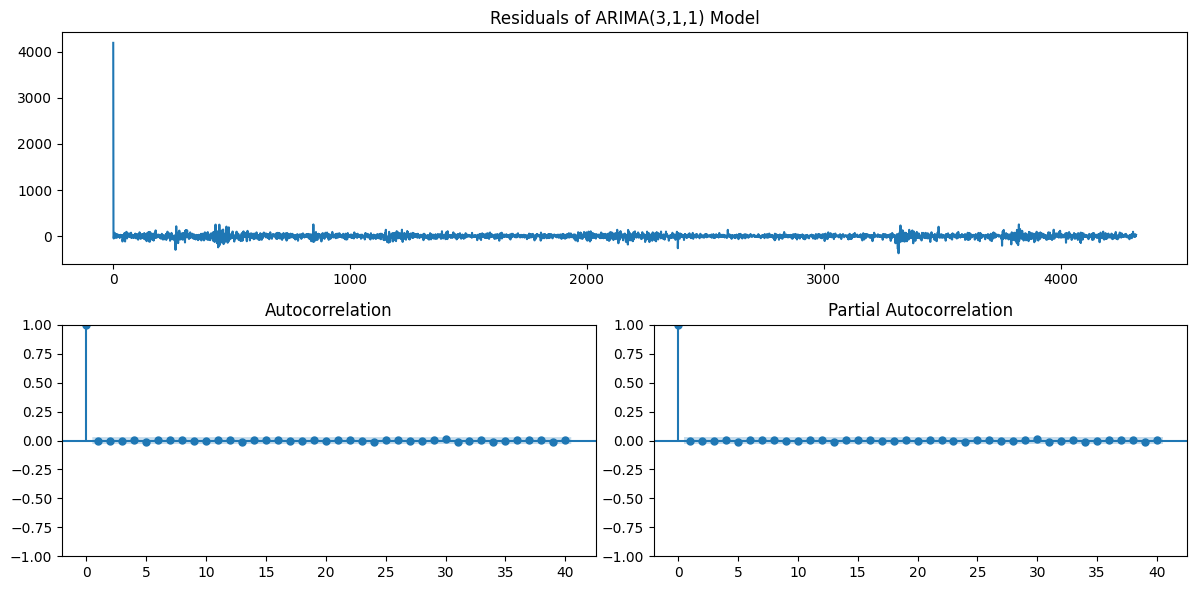

     lb_stat  lb_pvalue
10  1.291109   0.999452


In [66]:
# Residuals from the ARIMA(3,1,1) model
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals of ARIMA(3,1,1) Model')

# Plot ACF and PACF
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.subplot(223))
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=plt.subplot(224))
plt.tight_layout()
plt.show()

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

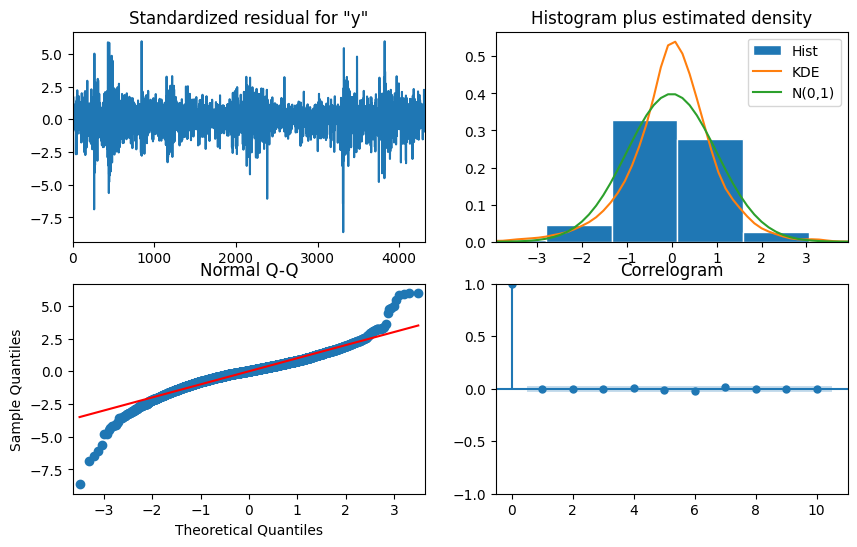

In [67]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.show()

## 4- Build and Evaluate AUTOARIMA Models

### 4.1 AutoArima

### 4.2 AutoARIMA with Exogenous Variables

### 4.3 AutoARIMA with Exogenous Variables - Cross-Validation

In [68]:
# Endogenous variable (target variable)
endog = dataset_knn_pandas['Close']

# Exogenous variables (including all financial indicators)
exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
                                'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

# Handle missing values
endog = endog.ffill().bfill()
exog_vars = exog_vars.ffill().bfill()

# Verify no NaN values remain
if endog.isna().any():
    raise ValueError("NaNs found in endogenous variable after filling.")
if exog_vars.isna().any().any():
    raise ValueError("NaNs found in exogenous variables after filling.")

# Split data into training and testing sets
split_point = int(len(endog) * 0.8)
train_endog = endog.iloc[:split_point]
test_endog = endog.iloc[split_point:]
train_exog = exog_vars.iloc[:split_point]
test_exog = exog_vars.iloc[split_point:]

In [69]:
def run_and_save_autoarima_model(train_endog, train_exog):
    # Fit the auto_arima model on the training data
    auto_model = auto_arima(
        train_endog,
        exogenous=train_exog,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        max_order=None
    )

    # Save the trained model
    joblib.dump(auto_model, 'autoarima_model_with_exogenous.pkl')
    print("Model saved as 'autoarima_model_with_exogenous.pkl'")

    return auto_model

# Run the function to train and save the model
auto_model = run_and_save_autoarima_model(train_endog, train_exog)

# Display the selected model order
print(f"Selected ARIMA Order: {auto_model.order}")
print(f"Selected Seasonal Order: {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=35739.181, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35738.632, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35736.601, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35736.606, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35736.780, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35738.599, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35738.588, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35740.601, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35734.761, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35736.758, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35736.744, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35734.766, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35738.760, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.312 seconds
Model sav

In [70]:
def load_model_and_generate_predictions(train_endog, train_exog, test_endog, test_exog, forecast_horizon=5, lookback_window=None):
    # Load the saved model
    auto_model = joblib.load('autoarima_model_with_exogenous.pkl')
    print("Model loaded from 'autoarima_model_with_exogenous.pkl'")

    # Initialize variables
    history_endog = train_endog.copy()
    history_exog = train_exog.copy()
    predictions = []

    # Generate predictions using a rolling forecast with the specified horizon
    for t in range(0, len(test_endog), forecast_horizon):
        # Create a deep copy of the model
        model = copy.deepcopy(auto_model)
        model.update(history_endog, exogenous=history_exog)

        steps = min(forecast_horizon, len(test_endog) - t)
        exog_forecast = test_exog.iloc[t:t+steps]

        # Generate forecast
        pred = model.predict(n_periods=steps, exogenous=exog_forecast)
        predictions.extend(pred)

        # Update history with the actual observed values
        history_endog = pd.concat([history_endog, test_endog.iloc[t:t+steps]])
        history_exog = pd.concat([history_exog, test_exog.iloc[t:t+steps]])

        # Apply lookback window if specified
        if lookback_window is not None:
            history_endog = history_endog.iloc[-lookback_window:]
            history_exog = history_exog.iloc[-lookback_window:]

    # Convert predictions to a Pandas Series and align with test data
    predicted_series = pd.Series(predictions, index=test_endog.index[:len(predictions)])

    # Align test and predicted series
    test_endog_aligned = test_endog.iloc[:len(predicted_series)]

    return test_endog_aligned, predicted_series

# Generate predictions with a 5-day forecast horizon
test_endog_aligned, predicted_series = load_model_and_generate_predictions(
    train_endog, train_exog, test_endog, test_exog, forecast_horizon=5, lookback_window=None
)

# Function to calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def calculate_evaluation_metrics(test_actual, test_predicted):
    rmse = sqrt(mean_squared_error(test_actual, test_predicted))
    r2 = r2_score(test_actual, test_predicted)
    mape = np.mean(np.abs((test_actual - test_predicted) / test_actual)) * 100
    return rmse, r2, mape

# Calculate metrics
rmse, r2, mape = calculate_evaluation_metrics(test_endog_aligned, predicted_series)

# Display the results
print("\nEvaluation Metrics:")
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}%")

Model loaded from 'autoarima_model_with_exogenous.pkl'

Evaluation Metrics:
RMSE: 68.80994288011046
R^2 Score: 0.9611188327994816
MAPE: 1.27685354489079%


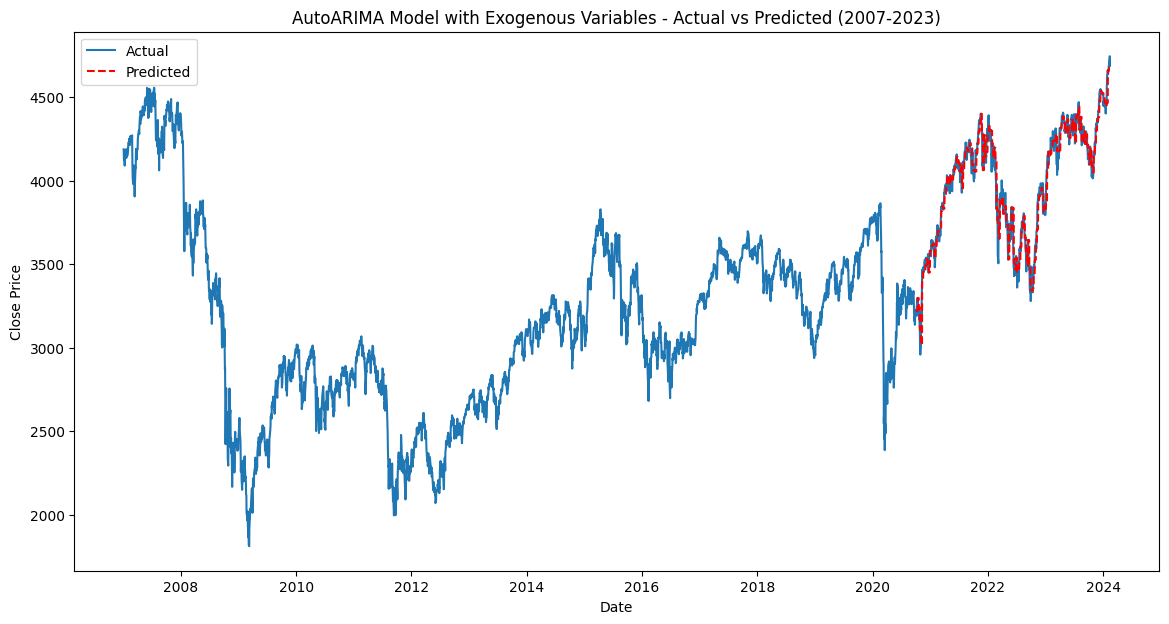

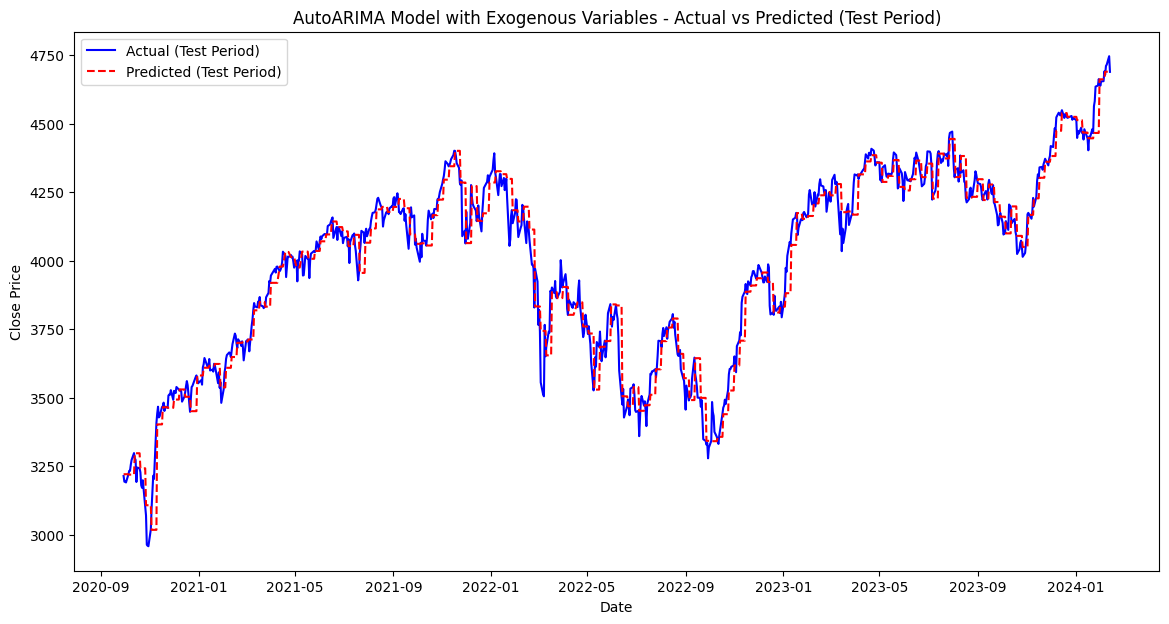

In [71]:
# Plot actual vs predicted values for the entire period
plt.figure(figsize=(14, 7))
plt.plot(endog, label='Actual')
plt.plot(predicted_series, label='Predicted', color='red', linestyle='dashed')
plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (2007-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Zoom in on the test period
plt.figure(figsize=(14, 7))
plt.plot(test_endog_aligned.index, test_endog_aligned, label='Actual (Test Period)', color='blue')
plt.plot(predicted_series.index, predicted_series, label='Predicted (Test Period)', color='red', linestyle='dashed')
plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

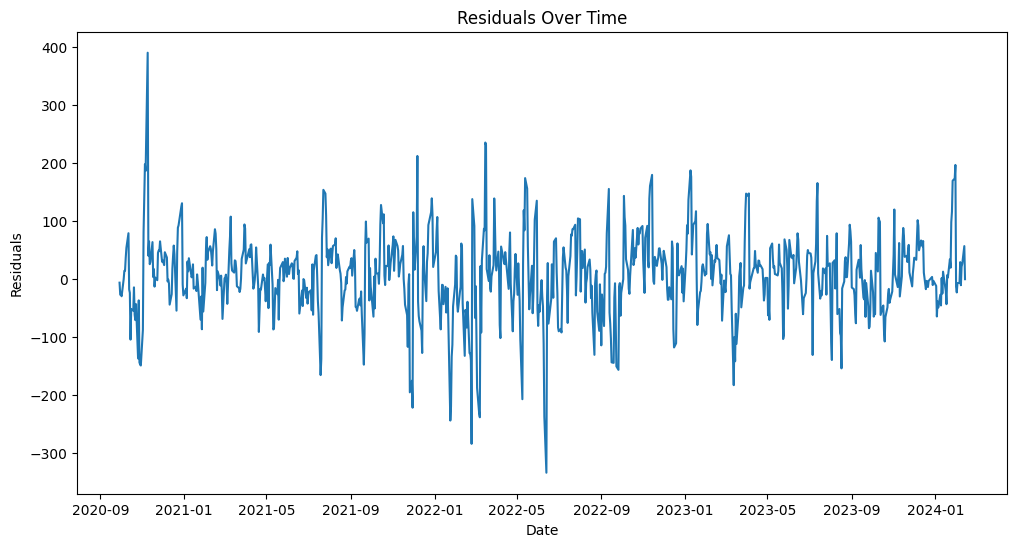

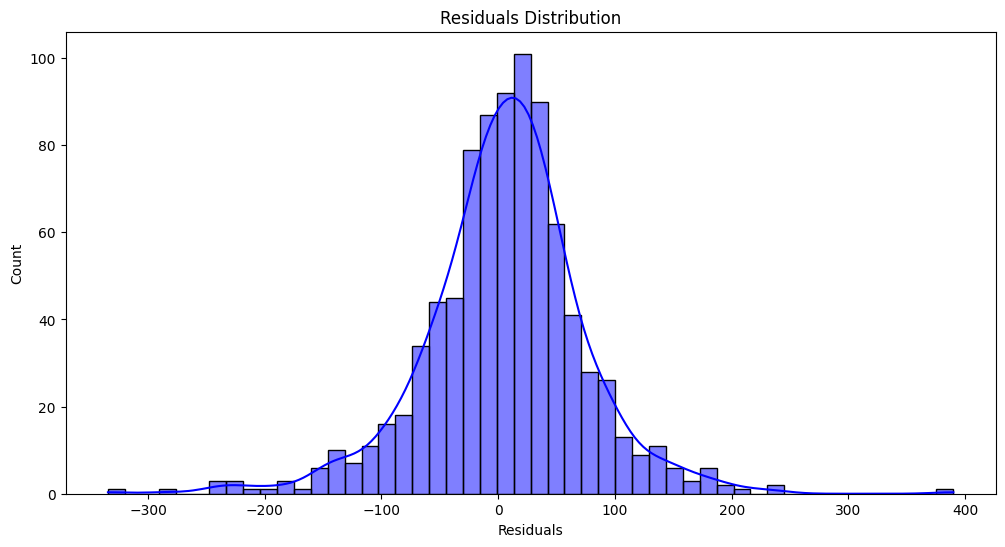


Ljung-Box Test:
       lb_stat     lb_pvalue
10  468.676833  2.161356e-94


In [72]:
# Calculate residuals
residuals = test_endog_aligned - predicted_series

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot residuals distribution
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(lb_test)

## 5- ARIMA with Exogenous Variables RNN (LSTM)

### Data Preparation

In [73]:
def prepare_data(dataset_knn_pandas, window_size=5):
    # Extract 'Close' series and exogenous variables
    series = dataset_knn_pandas['Close'].values.reshape(-1, 1)
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
                                    'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']].values
    
    # Initialize scalers
    scaler_series = MinMaxScaler(feature_range=(0, 1))
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    
    # Fit scalers and transform data
    series_scaled = scaler_series.fit_transform(series)
    exog_vars_scaled = scaler_exog.fit_transform(exog_vars)
    
    # Prepare sequences
    X, y = [], []
    for i in range(window_size, len(series_scaled)):
        # Combine series and exogenous variables
        X_series = series_scaled[i - window_size:i]
        X_exog = exog_vars_scaled[i - window_size:i]
        X_combined = np.hstack((X_series, X_exog))
        X.append(X_combined)
        y.append(series_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    # Split data into training and testing sets
    split_point = int(len(X) * 0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    # Get corresponding dates
    dates = dataset_knn_pandas.index[window_size:]
    train_dates = dates[:split_point]
    test_dates = dates[split_point:]
    
    return X_train, X_test, y_train, y_test, scaler_series, scaler_exog, train_dates, test_dates

# Run the data preparation
X_train, X_test, y_train, y_test, scaler_series, scaler_exog, train_dates, test_dates = prepare_data(dataset_knn_pandas, window_size=5)

### LSTM Model Architecture

In [74]:
def create_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_lstm_model(input_shape, units=50, dropout_rate=0.2)

### Training the Model

27/27 [==============================] - 1s 2ms/step
RMSE: 52.60588107181729
R2 Score: 0.9771722017750076
MAPE: 1.0450338131011823%


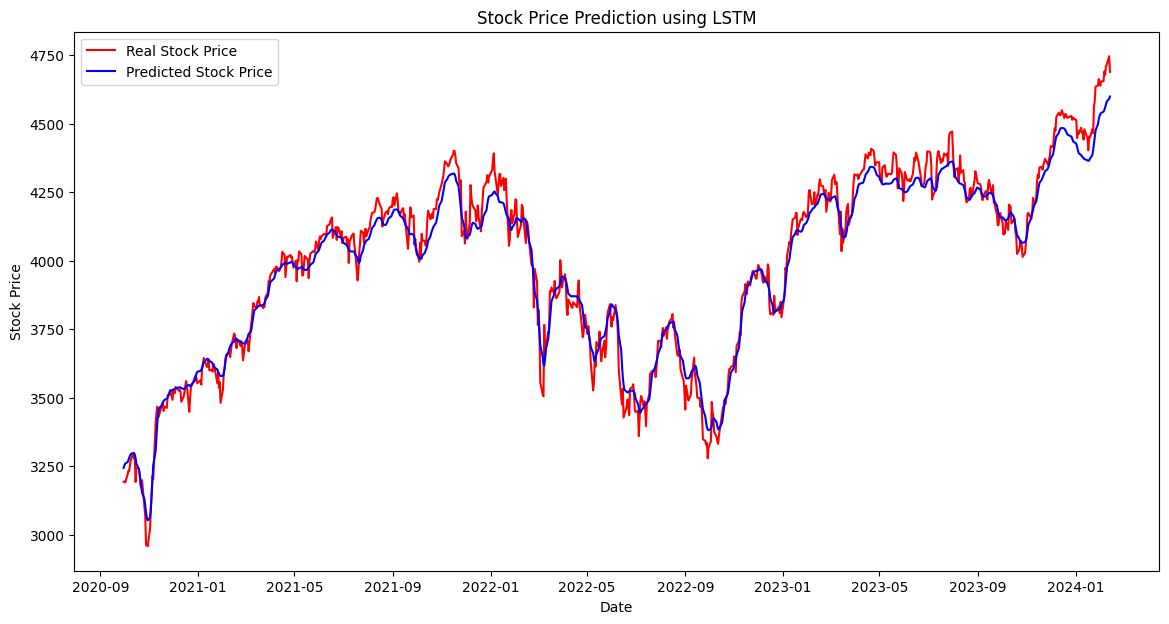

In [75]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Predict on the test set
predicted_stock_price = lstm_model.predict(X_test)
predicted_stock_price = scaler_series.inverse_transform(predicted_stock_price)
real_stock_price = scaler_series.inverse_transform(y_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
r2 = r2_score(real_stock_price, predicted_stock_price)
mape = np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print(f"MAPE: {mape}%")

# Adjust lengths to match
min_length = min(len(test_dates), len(real_stock_price))
test_dates_aligned = test_dates[:min_length]
real_stock_price = real_stock_price[:min_length]
predicted_stock_price = predicted_stock_price[:min_length]

# Plot the results with Date Index
plt.figure(figsize=(14, 7))
plt.plot(test_dates_aligned, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_dates_aligned, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Evaluate the Model

Model saved as lstm_model.h5
45/45 [==============================] - 0s 2ms/step
Train RMSE: 34.369078760723184
Test RMSE: 40.735742419839056
Test MAPE: 0.825446378129668
Test R²: 0.9917317660278783


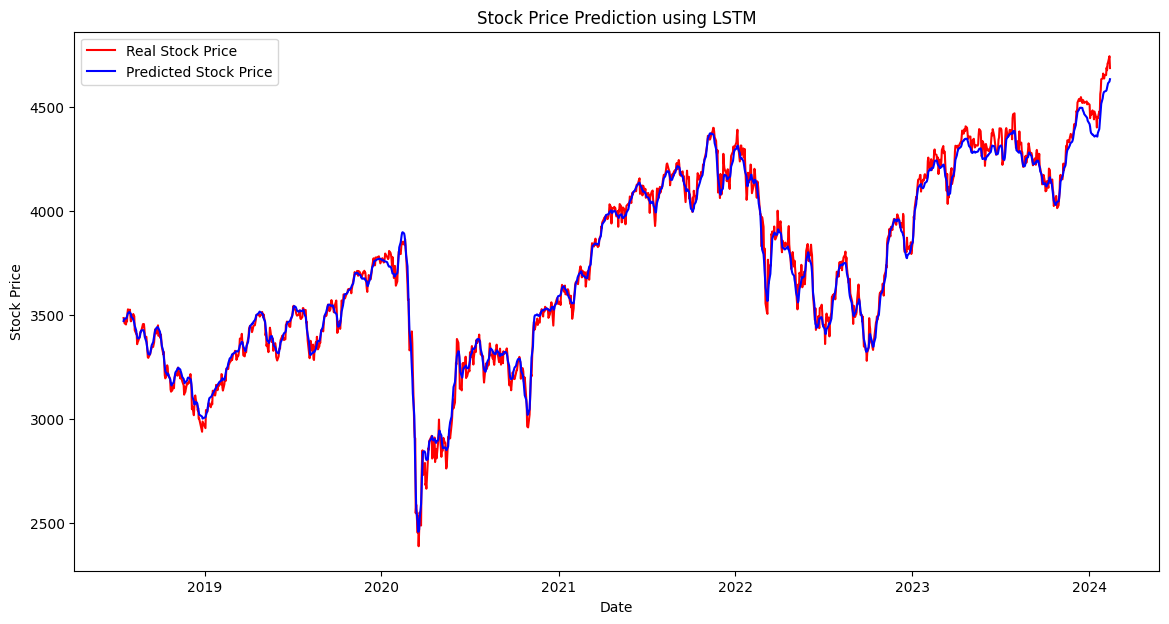

In [76]:
# Define the columns
feature_columns = ['Close', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']
target_column = 'Close'

# Normalizing the data
scaler_series = MinMaxScaler(feature_range=(0, 1))
scaler_exog = MinMaxScaler(feature_range=(0, 1))

series = dataset_knn_pandas['Close'].values.reshape(-1, 1)
exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
                                'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']].values

series_scaled = scaler_series.fit_transform(series)
exog_vars_scaled = scaler_exog.fit_transform(exog_vars)

# Create dataset with lagged features
def create_dataset(series_scaled, exog_vars_scaled, look_back=30):
    X, y = [], []
    for i in range(look_back, len(series_scaled)):
        X_series = series_scaled[i - look_back:i]
        X_exog = exog_vars_scaled[i - look_back:i]
        X_combined = np.hstack((X_series, X_exog))
        X.append(X_combined)
        y.append(series_scaled[i])
    return np.array(X), np.array(y)

# Prepare the dataset
look_back = 30  # 30 days look_back
X, y = create_dataset(series_scaled, exog_vars_scaled, look_back)

# Get corresponding dates
dates = dataset_knn_pandas.index[look_back:]
train_size = int(len(X) * 0.67)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_dates, test_dates = dates[:train_size], dates[train_size:]

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# Save the model
model.save('lstm_model.h5')
print("Model saved as lstm_model.h5")

# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions to get them back to the original scale
trainPredict = scaler_series.inverse_transform(trainPredict)
testPredict = scaler_series.inverse_transform(testPredict)
y_train_original = scaler_series.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler_series.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train_original, trainPredict))
test_rmse = np.sqrt(mean_squared_error(y_test_original, testPredict))
test_mape = np.mean(np.abs((y_test_original - testPredict) / y_test_original)) * 100
test_r2 = r2_score(y_test_original, testPredict)

# Print the performance metrics
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test R²:', test_r2)

# Adjust lengths to match
min_length = min(len(test_dates), len(y_test_original))
test_dates_aligned = test_dates[:min_length]
y_test_original = y_test_original[:min_length]
testPredict = testPredict[:min_length]

# Plotting the results with Date Index
plt.figure(figsize=(14, 7))
plt.plot(test_dates_aligned, y_test_original, color='red', label='Real Stock Price')
plt.plot(test_dates_aligned, testPredict, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Hyperparameter Tuning with Optuna

#### Model Evaluation

#### Overfitting/Underfitting Analysis

#### Hyperbolic Tangent (Tanh & Sigmoid)

### Retrain the LSTM Model with Hyperparameters

# ARIMA - AUTOARIMA - LSTM / Analyze

## 1- Load and Evaluate the ARIMA Model

In [77]:
def load_arima_model_results():

    # Load the saved ARIMA model
    model_filename = 'arima_model_order_(3, 1, 1).pkl'
    model_fit = joblib.load(model_filename)
    print(f"Model loaded from '{model_filename}'")

    # Extract the 'Close' series
    series = dataset_knn_pandas['Close']

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    train = series.iloc[:split_point]
    test = series.iloc[split_point:]

    # Initialize history with training data
    history = train.tolist()
    predictions = []

    # Perform rolling forecast
    for t in range(len(test)):
        # Re-fit the model with the updated history
        model = ARIMA(history, order=(3, 1, 1))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Update the history with the actual observation
        history.append(test.iloc[t])

    # Create a series for the predicted values with the same index as the test data
    predicted_series = pd.Series(predictions, index=test.index)

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test, predicted_series))
    r2 = r2_score(test, predicted_series)
    mape = np.mean(np.abs((test - predicted_series) / test)) * 100

    # Save results to be used later for comparison
    arima_metrics = {'RMSE': rmse, 'R2': r2, 'MAPE': mape}

    return test, predicted_series, arima_metrics

# Usage
arima_test, arima_predicted, arima_metrics = load_arima_model_results()

Model loaded from 'arima_model_order_(3, 1, 1).pkl'


## 2- Load and Evaluate the AutoARIMA Model

In [78]:
def load_autoarima_results():

    # Load the saved AutoARIMA model
    auto_model = joblib.load('autoarima_model_with_exogenous.pkl')
    print("Model loaded from 'autoarima_model_with_exogenous.pkl'")

    # Extract the 'Close' series and the exogenous variables
    series = dataset_knn_pandas['Close']
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
                                    'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

    # Ensure there are no NaN values
    exog_vars = exog_vars.ffill().bfill()
    series = series.ffill().bfill()

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    train_endog = series.iloc[:split_point]
    test_endog = series.iloc[split_point:]
    train_exog = exog_vars.iloc[:split_point]
    test_exog = exog_vars.iloc[split_point:]

    # Initialize variables
    history_endog = train_endog.copy()
    history_exog = train_exog.copy()
    predictions = []

    # Generate predictions using rolling forecast
    for t in range(len(test_endog)):
        # Create a deep copy of the model
        model = copy.deepcopy(auto_model)
        # Update the model with the current history
        model.update(history_endog, exogenous=history_exog)

        # Forecast the next time step
        exog_forecast = test_exog.iloc[t:t+1]
        pred = model.predict(n_periods=1, exogenous=exog_forecast)
        predictions.extend(pred)

        # Update history with the actual observed values
        history_endog = pd.concat([history_endog, test_endog.iloc[t:t+1]])
        history_exog = pd.concat([history_exog, test_exog.iloc[t:t+1]])

    # Create a series for the predicted values with the same index as the test data
    predicted_series = pd.Series(predictions, index=test_endog.index)

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test_endog, predicted_series))
    r2 = r2_score(test_endog, predicted_series)
    mape = np.mean(np.abs((test_endog - predicted_series) / test_endog)) * 100

    # Save results to be used later for comparison
    autoarima_metrics = {'RMSE': rmse, 'R2': r2, 'MAPE': mape}

    return test_endog, predicted_series, autoarima_metrics

# Call the function and get the AutoARIMA results
autoarima_test, autoarima_predicted, autoarima_metrics = load_autoarima_results()

Model loaded from 'autoarima_model_with_exogenous.pkl'


## 3- Load and Evaluate the LSTM Model

In [79]:
def load_lstm_results():

    # Load the adjusted LSTM model
    best_model_path = 'best_op_model.h5'  # Use 'best_model.h5' if that's the best model
    best_model = load_model(best_model_path)
    print(f"Model loaded from '{best_model_path}'")

    # Predict on the test set
    predicted_stock_price = best_model.predict(X_test)
    predicted_stock_price = scaler_series.inverse_transform(predicted_stock_price).flatten()
    real_stock_price_series = scaler_series.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Adjust lengths to match
    min_length = min(len(test_dates), len(real_stock_price_series))
    test_dates_aligned = test_dates[:min_length]
    real_stock_price_series = real_stock_price_series[:min_length]
    predicted_stock_price = predicted_stock_price[:min_length]

    # Evaluate the model
    rmse = sqrt(mean_squared_error(real_stock_price_series, predicted_stock_price))
    mape = np.mean(np.abs((real_stock_price_series - predicted_stock_price) / real_stock_price_series)) * 100
    r2 = r2_score(real_stock_price_series, predicted_stock_price)

    # Save results to be used later for comparison
    lstm_metrics = {'RMSE': rmse, 'R2': r2, 'MAPE': mape}

    return real_stock_price_series, predicted_stock_price, lstm_metrics

# Usage
lstm_real, lstm_predicted, lstm_metrics = load_lstm_results()

Model loaded from 'best_op_model.h5'
45/45 [==============================] - 0s 6ms/step


## 4- Comparative Metrics

In [81]:
# Create a DataFrame to compare the results of ARIMA, AutoARIMA (with exogenous variables), and LSTM
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'AutoARIMA', 'LSTM'],
    'RMSE': [arima_metrics['RMSE'], autoarima_metrics['RMSE'], lstm_metrics['RMSE']],
    'R2': [arima_metrics['R2'], autoarima_metrics['R2'], lstm_metrics['R2']],
    'MAPE': [arima_metrics['MAPE'], autoarima_metrics['MAPE'], lstm_metrics['MAPE']]
})

# Print the comparison table
print(comparison_df)

# Save the comparison results to a CSV file for further analysis
comparison_df.to_csv('arima_autoarima_lstm_comparison.csv', index=False)

print("Results saved to 'arima_autoarima_lstm_comparison.csv'")

       Model       RMSE        R2      MAPE
0      ARIMA  43.636733  0.984363  0.803717
1  AutoARIMA  43.679175  0.984333  0.805200
2       LSTM  47.383378  0.988813  0.973907
Results saved to 'arima_autoarima_lstm_comparison.csv'


       Model       RMSE        R2      MAPE
0      ARIMA  43.636733  0.984363  0.803717
1  AutoARIMA  43.679175  0.984333  0.805200
2       LSTM  47.383378  0.988813  0.973907
Results saved to 'arima_autoarima_lstm_comparison.csv'


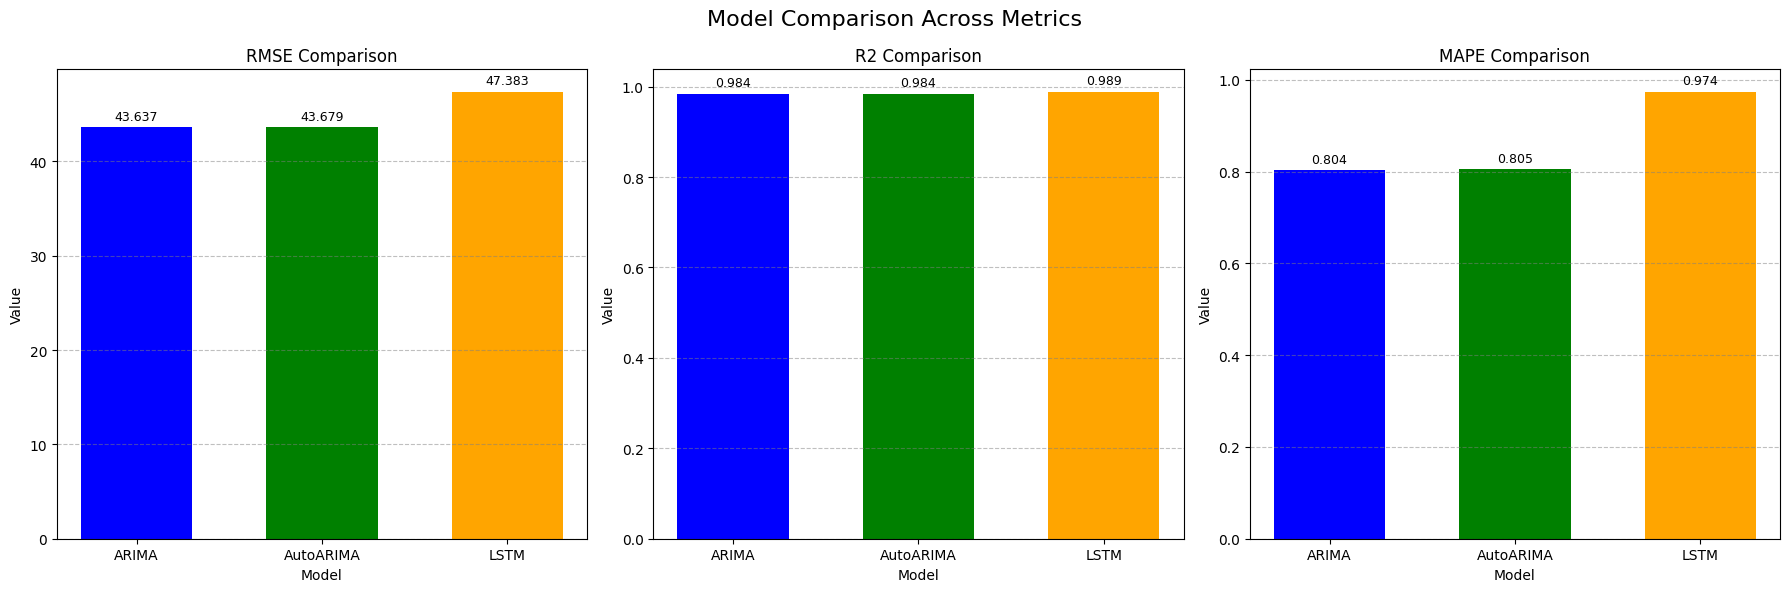

In [84]:
# Print the comparison table
print(comparison_df)

# Save the comparison results to a CSV file for further analysis
comparison_df.to_csv('arima_autoarima_lstm_comparison.csv', index=False)
print("Results saved to 'arima_autoarima_lstm_comparison.csv'")

# Define the list of metrics, models, and colors
metrics = ['RMSE', 'R2', 'MAPE']
models = ['ARIMA', 'AutoARIMA', 'LSTM']
colors = {'ARIMA': 'blue', 'AutoARIMA': 'green', 'LSTM': 'orange'}

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, metric in enumerate(metrics):
    # Extract values for the current metric
    values = comparison_df[metric].values
    
    # Create a bar plot for the current metric
    axes[i].bar(models, values, color=[colors[model] for model in models], width=0.6)
    axes[i].set_title(f'{metric} Comparison', fontsize=12)
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('Model')
    axes[i].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Add value labels on top of each bar
    for j, value in enumerate(values):
        axes[i].text(j, value + 0.01 * abs(value), f'{value:.3f}',
                     ha='center', va='bottom', fontsize=9)

# Set the overall title and adjust layout
fig.suptitle('Model Comparison Across Metrics', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Plot training & validation loss values for adjusted model
plt.figure(figsize=(10, 6))
plt.plot(history_adjusted.history['loss'], label='Training Loss')
plt.plot(history_adjusted.history['val_loss'], label='Validation Loss')
plt.title('Adjusted Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 5- Prediction vs Actual Plot for ARIMA and LSTM

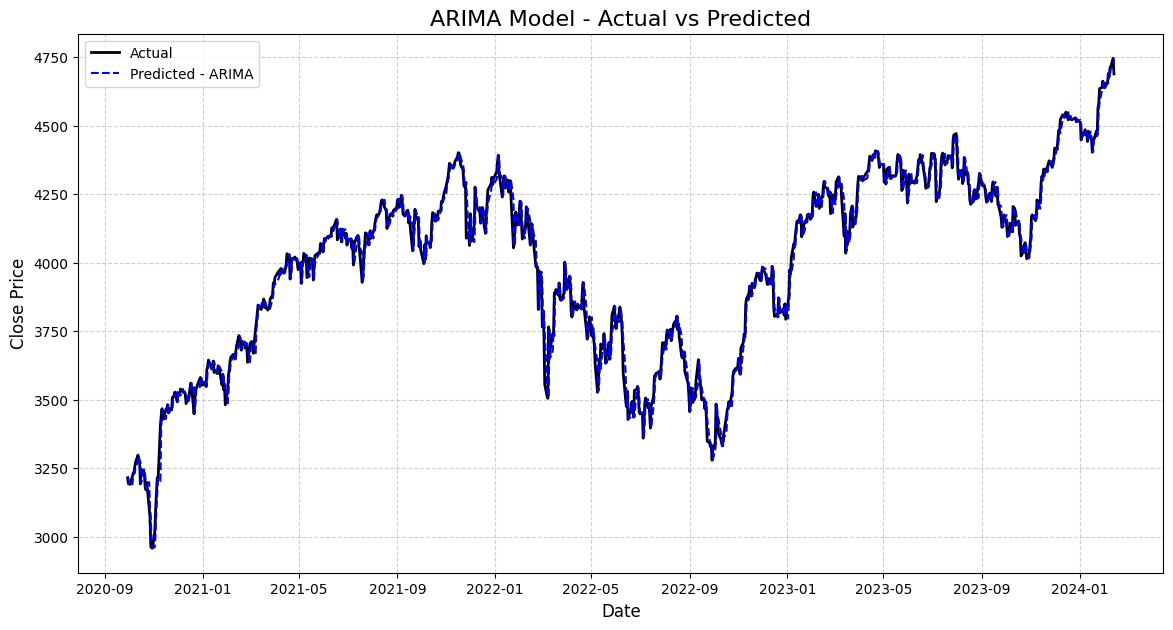

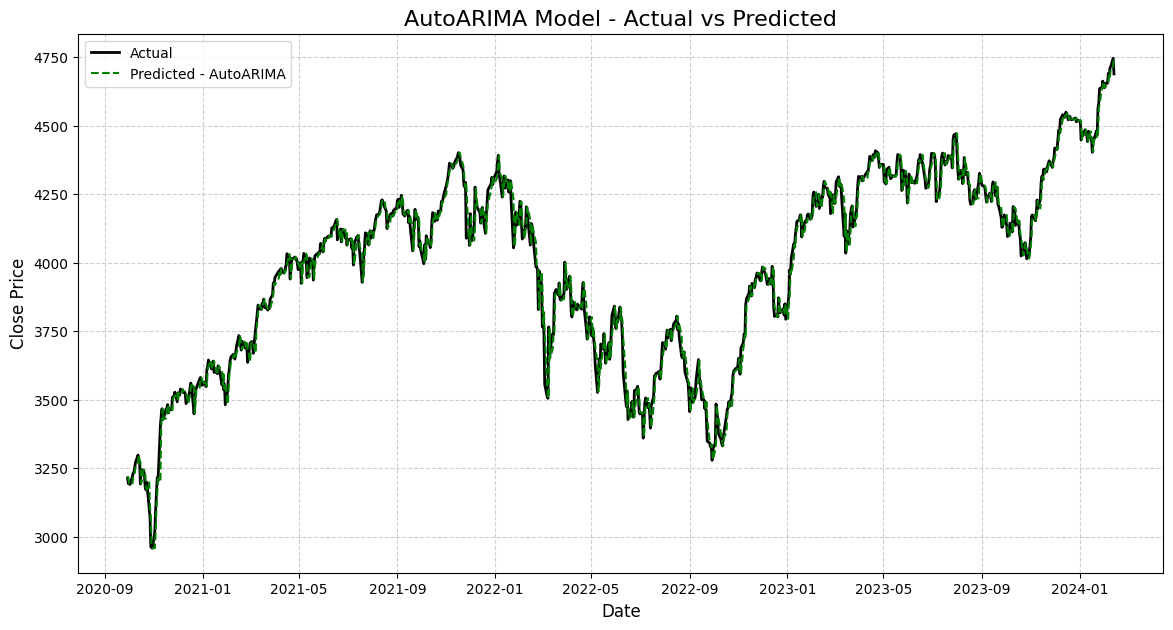

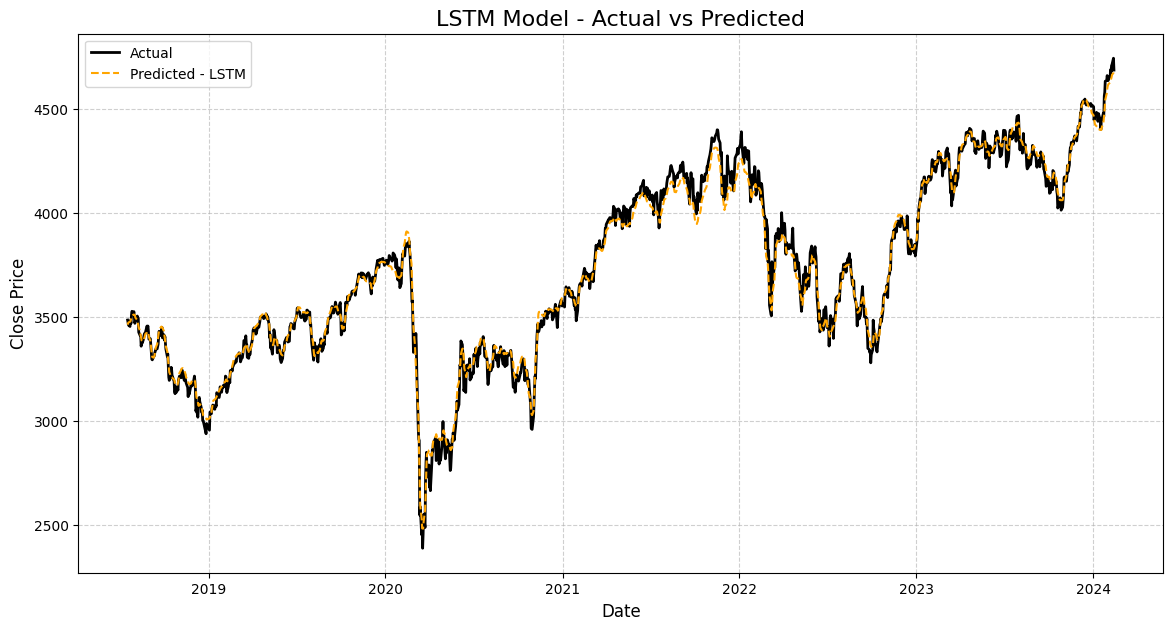

In [89]:
# ----------------------- Variable Definitions ----------------------- #

# For LSTM Model
# look_back'
look_back = 30 

# Calculate the number of training samples
num_train_samples = len(X_train)

# Get the indices for the test set
test_indices = range(num_train_samples + look_back, len(dataset_knn_pandas))

# Extract the dates corresponding to the test set
lstm_test_dates = dataset_knn_pandas.index[test_indices]

# Align the dates with the predictions (since predictions start after 'look_back' steps)
lstm_test_dates_aligned = lstm_test_dates

# Extract the actual 'Close' prices for the test set
lstm_real = dataset_knn_pandas['Close'].iloc[test_indices].values

# Ensure 'lstm_predicted' is a NumPy array
lstm_predicted = lstm_predicted.flatten()

# ----------------------- Plotting ----------------------- #

# ARIMA vs Actual
plt.figure(figsize=(14, 7))
plt.plot(arima_test.index, arima_test, color='black', label='Actual', linewidth=2)
plt.plot(arima_predicted.index, arima_predicted, color='blue', label='Predicted - ARIMA', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# AutoARIMA vs Actual
plt.figure(figsize=(14, 7))
plt.plot(autoarima_test.index, autoarima_test, color='black', label='Actual', linewidth=2)
plt.plot(autoarima_predicted.index, autoarima_predicted, color='green', label='Predicted - AutoARIMA', linestyle='dashed')
plt.title('AutoARIMA Model - Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# LSTM vs Actual
plt.figure(figsize=(14, 7))
plt.plot(lstm_test_dates_aligned, lstm_real, color='black', label='Actual', linewidth=2)
plt.plot(lstm_test_dates_aligned, lstm_predicted, color='orange', label='Predicted - LSTM', linestyle='dashed')
plt.title('LSTM Model - Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


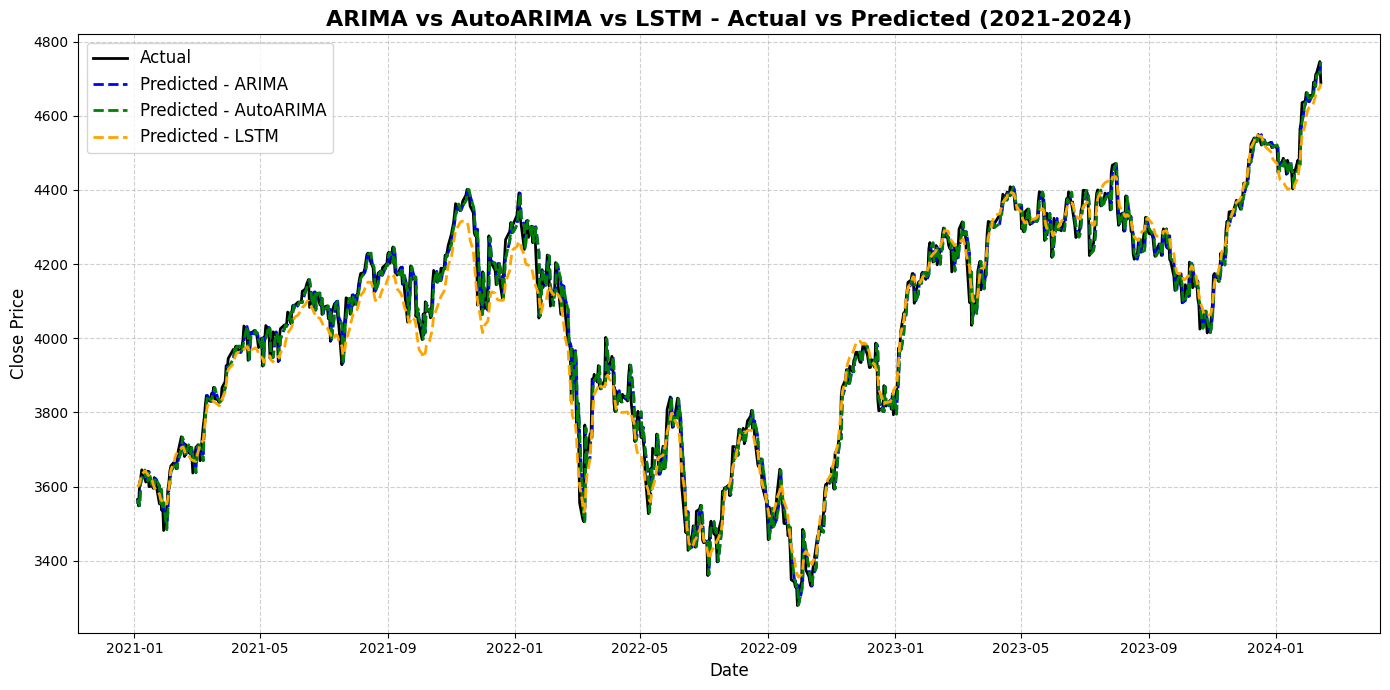

In [92]:
# Define the date range for the cut-off
start_date = '2021-01-01'
end_date = '2024-12-31'

# Filter the ARIMA test data for the date range
arima_test_filtered = arima_test.loc[start_date:end_date]
arima_predicted_filtered = arima_predicted.loc[start_date:end_date]

# Filter the AutoARIMA test data for the date range
autoarima_test_filtered = autoarima_test.loc[start_date:end_date]
autoarima_predicted_filtered = autoarima_predicted.loc[start_date:end_date]

# For LSTM Model
look_back = 30 

# Calculate the number of training samples
num_train_samples = len(X_train)

# Get the indices for the test set
test_indices = range(num_train_samples + look_back, len(dataset_knn_pandas))

# Extract the dates corresponding to the test set
test_dates = dataset_knn_pandas.index[test_indices]

# Extract the actual 'Close' prices for the test set
lstm_real = dataset_knn_pandas['Close'].iloc[test_indices].values

#'lstm_predicted' is a NumPy array
lstm_predicted = np.array(lstm_predicted).flatten()

# Adjust lengths to match
min_length = min(len(test_dates), len(lstm_predicted))
lstm_test_dates_aligned = test_dates[:min_length]
lstm_predicted_aligned = lstm_predicted[:min_length]
lstm_real_aligned = lstm_real[:min_length]

# Create a DataFrame for LSTM data
lstm_df = pd.DataFrame({
    'Date': lstm_test_dates_aligned,
    'Actual': lstm_real_aligned,
    'Predicted_LSTM': lstm_predicted_aligned
})
lstm_df.set_index('Date', inplace=True)

# Filter the LSTM data for the date range
lstm_filtered = lstm_df.loc[start_date:end_date]

# ----------------------- Aligning All Models ----------------------- #

# Find common dates across all models
common_dates = arima_test_filtered.index.intersection(autoarima_test_filtered.index).intersection(lstm_filtered.index)

# Filter all datasets to common dates
arima_test_filtered = arima_test_filtered.loc[common_dates]
arima_predicted_filtered = arima_predicted_filtered.loc[common_dates]

autoarima_test_filtered = autoarima_test_filtered.loc[common_dates]
autoarima_predicted_filtered = autoarima_predicted_filtered.loc[common_dates]

lstm_filtered = lstm_filtered.loc[common_dates]

# ----------------------- Plotting ----------------------- #

plt.figure(figsize=(14, 7))

# Plot Actual values
plt.plot(arima_test_filtered.index, arima_test_filtered, color='black', label='Actual', linewidth=2)

# Plot ARIMA predictions
plt.plot(arima_predicted_filtered.index, arima_predicted_filtered, color='blue', label='Predicted - ARIMA', linestyle='dashed', linewidth=2)

# Plot AutoARIMA predictions
plt.plot(autoarima_predicted_filtered.index, autoarima_predicted_filtered, color='green', label='Predicted - AutoARIMA', linestyle='dashed', linewidth=2)

# Plot LSTM predictions
plt.plot(lstm_filtered.index, lstm_filtered['Predicted_LSTM'], color='orange', label='Predicted - LSTM', linestyle='dashed', linewidth=2)

# Title and labels
plt.title('ARIMA vs AutoARIMA vs LSTM - Actual vs Predicted (2021-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# Add a legend for clarity
plt.legend(loc='best', fontsize=12)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## 6- Plot ARIMA, AUTOARIMA and LSTM Forecasts along with Actual Data

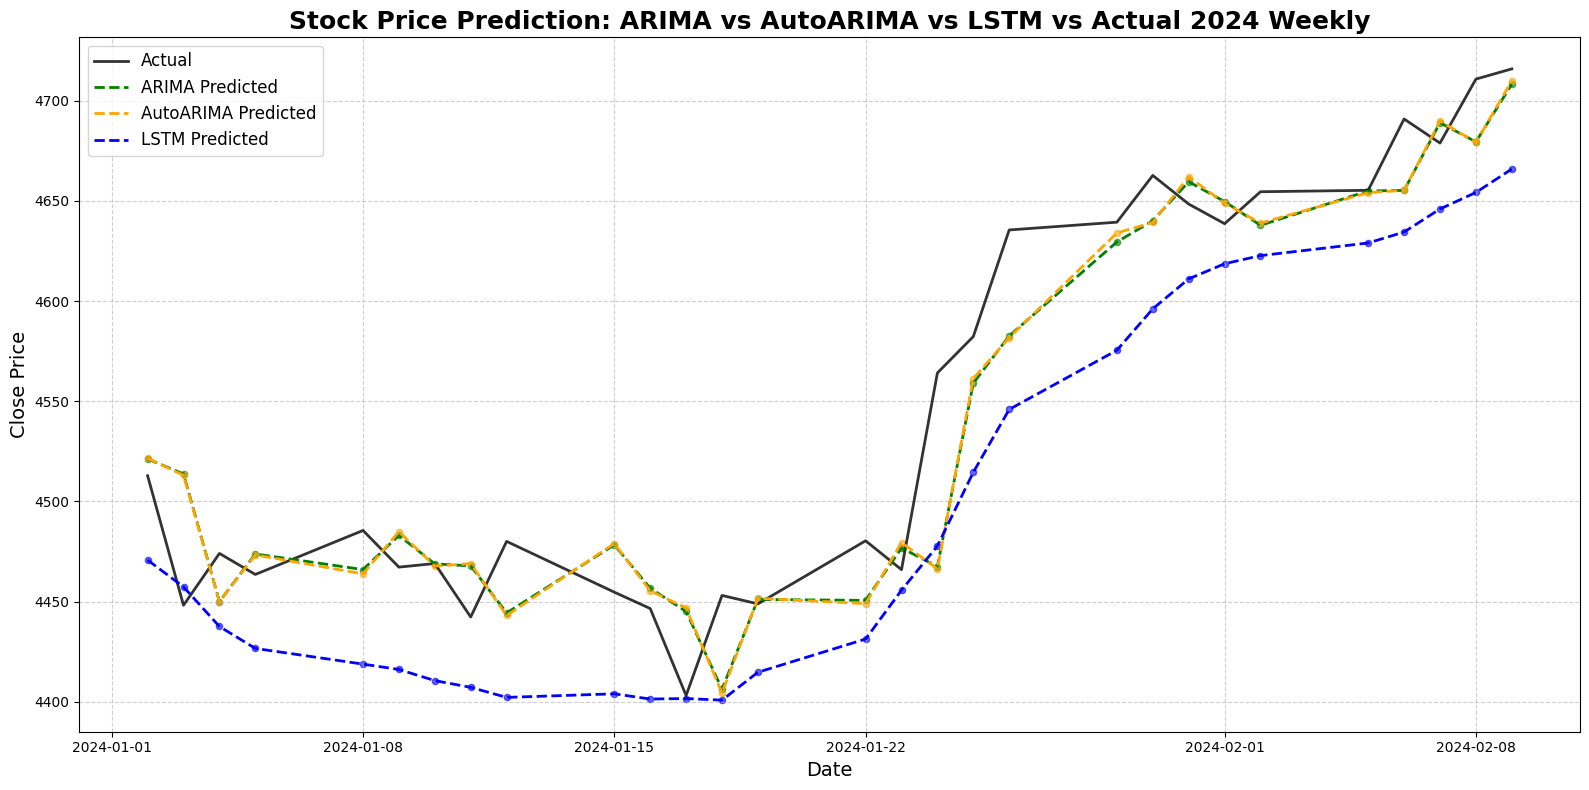

In [93]:
# Adjust lengths to match
min_length = min(len(test_dates), len(lstm_predicted))
lstm_test_dates_aligned = test_dates[:min_length]
lstm_predicted = lstm_predicted[:min_length]

# Now, update your plotting code:

# Define the start and end dates for the plot (2024-01-01 to 2024-02-09)
start_date = '2024-01-01'
end_date = '2024-02-09'

# Filter the data for the specified date range
actual_filtered = dataset_knn_pandas['Close'].loc[start_date:end_date]
lstm_predicted_series = pd.Series(lstm_predicted, index=lstm_test_dates_aligned)
lstm_predicted_filtered = lstm_predicted_series.loc[start_date:end_date]

arima_predicted_filtered = arima_predicted.loc[start_date:end_date]
autoarima_predicted_filtered = autoarima_predicted.loc[start_date:end_date]

# Plot the filtered actual series (2024)
plt.figure(figsize=(16, 8))
plt.plot(actual_filtered, label='Actual', color='black', linewidth=2, alpha=0.8)

# Plot the filtered ARIMA predictions
plt.plot(arima_predicted_filtered.index, arima_predicted_filtered, label='ARIMA Predicted', color='green', linestyle='dashed', linewidth=2)

# Plot the filtered AutoARIMA predictions
plt.plot(autoarima_predicted_filtered.index, autoarima_predicted_filtered, label='AutoARIMA Predicted', color='orange', linestyle='dashed', linewidth=2)

# Plot the filtered LSTM predictions
plt.plot(lstm_predicted_filtered.index, lstm_predicted_filtered, label='LSTM Predicted', color='blue', linestyle='dashed', linewidth=2)

# Add titles and labels
plt.title('Stock Price Prediction: ARIMA vs AutoARIMA vs LSTM vs Actual 2024 Weekly', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)

# Highlight the significant variations with markers
plt.scatter(arima_predicted_filtered.index, arima_predicted_filtered, color='green', s=20, alpha=0.6)
plt.scatter(autoarima_predicted_filtered.index, autoarima_predicted_filtered, color='orange', s=20, alpha=0.6)
plt.scatter(lstm_predicted_filtered.index, lstm_predicted_filtered, color='blue', s=20, alpha=0.6)

# Add the legend
plt.legend(loc='upper left', fontsize=12)

# Add gridlines to enhance readability
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


## 7-Day Forecast Horizon

In [121]:
# 5-Day Forecast Horizon
forecast_horizon = 5

# ------------------------- ARIMA Forecast -------------------------------- #
def forecast_arima():
    model_filename = 'arima_model_order_(3, 1, 1).pkl'
    model_fit = joblib.load(model_filename)
    print(f"ARIMA model loaded from '{model_filename}'")

    # Extract the 'Close' series
    series = dataset_knn_pandas['Close']

    # Forecast future values
    arima_forecast = model_fit.forecast(steps=forecast_horizon)

    # Create future dates
    last_date = dataset_knn_pandas.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=forecast_horizon, freq='D')

    # Create a series for the forecast with the future dates
    arima_forecast_series = pd.Series(arima_forecast, index=forecast_dates)
    print("ARIMA 5-day forecast completed.")

    return arima_forecast_series

# ----------------------- AutoARIMA Forecast ------------------------------ #
def forecast_autoarima():

    auto_model_fit = joblib.load('autoarima_model_with_exogenous.pkl')
    print("AutoARIMA model loaded.")

    # Try to get the expected number of exogenous variables
    try:
        expected_exog_dim = auto_model_fit.exog.shape[1]
        print(f"Expected number of exogenous variables: {expected_exog_dim}")
    except AttributeError:
        print("Could not determine expected number of exogenous variables.")
        expected_exog_dim = None

    # Ensure 'RSI' is calculated if it was used during training
    if 'RSI' not in dataset_knn_pandas.columns:
        def calculate_RSI(data, window=14):
            delta = data['Close'].diff(1)
            delta = delta.dropna()
            up = delta.clip(lower=0)
            down = -1 * delta.clip(upper=0)
            gain = up.rolling(window=window).mean()
            loss = down.rolling(window=window).mean()
            RS = gain / loss
            RSI = 100.0 - (100.0 / (1.0 + RS))
            return RSI

        # Calculate RSI and add to the dataset
        dataset_knn_pandas['RSI'] = calculate_RSI(dataset_knn_pandas)
        # Fill NaN values in 'RSI'
        dataset_knn_pandas['RSI'] = dataset_knn_pandas['RSI'].fillna(method='ffill').fillna(method='bfill')

    # Define the exogenous variables used during training
    exog_vars = ['MACD', 'SMA', 'EMA', 'RSI', 'InterestRate', 'InflationRate',
                 'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

    # Extract exogenous variables
    exog_vars_df = dataset_knn_pandas[exog_vars]

    # Get the last known values of exogenous variables
    last_exog_values = exog_vars_df.iloc[-1]

    # Create a DataFrame for future exogenous variables
    future_exog = pd.DataFrame([last_exog_values.values] * forecast_horizon, columns=exog_vars)

    # Ensure there are no NaN values
    future_exog = future_exog.fillna(method='ffill').fillna(method='bfill')

    # Convert all columns to numeric
    future_exog = future_exog.apply(pd.to_numeric, errors='coerce')

    # Check for NaN values after conversion
    if future_exog.isnull().any().any():
        print("Warning: NaN values found in future_exog after filling and conversion:")
        print(future_exog.isnull().sum())

    # Print future_exog for inspection
    print("Future Exogenous Variables (future_exog):")
    print(future_exog)
    print(f"Shape of future_exog: {future_exog.shape}")

    # Print expected exogenous variable dimension
    if expected_exog_dim is not None:
        print(f"Expected exogenous variables: {expected_exog_dim}")

    # Forecast for the next 5 days using 'exogenous' parameter
    try:
        autoarima_forecast = auto_model_fit.predict(n_periods=forecast_horizon, exogenous=future_exog)
        print("AutoARIMA 5-day forecast completed.")
    except Exception as e:
        print("An error occurred during AutoARIMA prediction:")
        print(e)
        traceback.print_exc()
        autoarima_forecast = [np.nan] * forecast_horizon

    # Create future dates
    last_date = dataset_knn_pandas.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

    # Create a series for the forecast with the future dates
    autoarima_forecast_series = pd.Series(autoarima_forecast, index=forecast_dates)

    return autoarima_forecast_series

# ----------------------- LSTM Forecast ------------------------------------ #
def forecast_lstm():
    best_model = load_model('best_op_model.h5')
    print("LSTM model loaded.")

    # Use the same 'look_back'
    look_back = 30

    # Include all features used during training
    feature_columns = ['Close', 'MACD', 'SMA', 'EMA', 'RSI', 'InterestRate', 'InflationRate',
                       'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

    # 'RSI' is calculated if not present
    if 'RSI' not in dataset_knn_pandas.columns:
        def calculate_RSI(data, window=14):
            delta = data['Close'].diff(1)
            up = delta.clip(lower=0)
            down = -1 * delta.clip(upper=0)
            gain = up.rolling(window=window).mean()
            loss = down.rolling(window=window).mean()
            RS = gain / loss
            RSI = 100.0 - (100.0 / (1.0 + RS))
            return RSI

        # Calculate RSI and add to the dataset
        dataset_knn_pandas['RSI'] = calculate_RSI(dataset_knn_pandas)
        # Fill NaN values in 'RSI'
        dataset_knn_pandas['RSI'] = dataset_knn_pandas['RSI'].fillna(method='bfill').fillna(method='ffill')

    # Prepare the last 'look_back' days of data
    last_data = dataset_knn_pandas[feature_columns].iloc[-look_back:]

    # No NaN values
    last_data = last_data.ffill().bfill()

    # Min-Max scaling was used
    min_values = last_data.min()
    max_values = last_data.max()
    last_data_normalized = (last_data - min_values) / (max_values - min_values)

    # Prepare the input sequence
    input_seq = last_data_normalized.values

    # Reshape to [samples, time_steps, features]
    input_seq = input_seq.reshape(1, look_back, len(feature_columns))

    lstm_forecast = []
    for _ in range(forecast_horizon):
        # Predict the next value
        pred = best_model.predict(input_seq)

        # Inverse transform the prediction
        predicted_close = pred[0, feature_columns.index('Close')] * (max_values['Close'] - min_values['Close']) + min_values['Close']

        lstm_forecast.append(predicted_close)

        # Update the input sequence
        last_features = input_seq[0, -1, :].copy()

        # Update 'Close' with the predicted value (normalized)
        last_features[feature_columns.index('Close')] = (predicted_close - min_values['Close']) / (max_values['Close'] - min_values['Close'])

        # Append the new feature vector to the sequence
        input_seq = np.append(input_seq[:, 1:, :],
                              last_features.reshape(1, 1, len(feature_columns)), axis=1)

    # Convert predictions to a numpy array
    lstm_forecast = np.array(lstm_forecast)

    # Create future dates
    last_date = dataset_knn_pandas.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=forecast_horizon, freq='D')

    # Create a series for the forecast
    lstm_forecast_series = pd.Series(lstm_forecast.flatten(), index=forecast_dates)
    print("LSTM 5-day forecast completed.")

    return lstm_forecast_series

# --------------------- Export Forecasts ----------------------------------- #
def export_forecasts():
    arima_forecast = forecast_arima()
    autoarima_forecast = forecast_autoarima()
    lstm_forecast = forecast_lstm()

    # Combine the forecasts into a DataFrame
    forecast_df = pd.DataFrame({
        'Date': arima_forecast.index,
        'ARIMA_Forecast': arima_forecast.values,
        'AutoARIMA_Forecast': autoarima_forecast.values,
        'LSTM_Forecast': lstm_forecast.values
    })

    # Export the forecast to a CSV file
    forecast_df.to_csv('model_forecasts_5_days.csv', index=False)
    print("Forecasts exported to 'model_forecasts_5_days.csv'")

# ------------------ Call the export function ------------------ #
export_forecasts()

ARIMA model loaded from 'arima_model_order_(3, 1, 1).pkl'
ARIMA 5-day forecast completed.
AutoARIMA model loaded.
Could not determine expected number of exogenous variables.
Future Exogenous Variables (future_exog):
        MACD          SMA          EMA        RSI  InterestRate  \
0 -10.277905  4726.380005  4758.118811  70.088206       3.91808   
1 -10.277905  4726.380005  4758.118811  70.088206       3.91808   
2 -10.277905  4726.380005  4758.118811  70.088206       3.91808   
3 -10.277905  4726.380005  4758.118811  70.088206       3.91808   
4 -10.277905  4726.380005  4758.118811  70.088206       3.91808   

   InflationRate       M3       M6       Y1       Y3       Y5      Y10  \
0           2.62  3.89022  3.67241  3.33961  2.81045  2.79897  3.08602   
1           2.62  3.89022  3.67241  3.33961  2.81045  2.79897  3.08602   
2           2.62  3.89022  3.67241  3.33961  2.81045  2.79897  3.08602   
3           2.62  3.89022  3.67241  3.33961  2.81045  2.79897  3.08602   
4          

In [122]:
# Read the forecasts
forecast_df = pd.read_csv('model_forecasts_5_days.csv', parse_dates=['Date'])

# Display the forecast DataFrame
print(forecast_df)

        Date  ARIMA_Forecast  AutoARIMA_Forecast  LSTM_Forecast
0 2024-02-14     4689.023065                 NaN    4786.761486
1 2024-02-15     4689.260284                 NaN    4794.612953
2 2024-02-16     4687.866503                 NaN    4799.797313
3 2024-02-17     4688.520747                 NaN    4803.382809
4 2024-02-18     4688.255620                 NaN    4805.893761


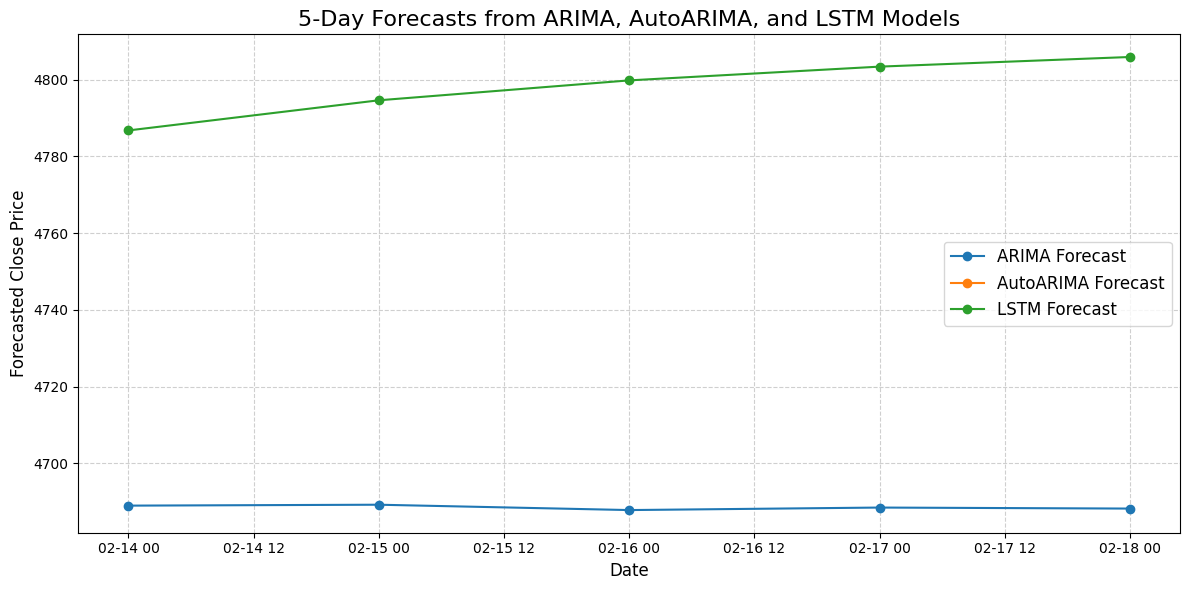

In [123]:
# Plot the forecasts
plt.figure(figsize=(12, 6))

plt.plot(forecast_df['Date'], forecast_df['ARIMA_Forecast'], label='ARIMA Forecast', marker='o')
plt.plot(forecast_df['Date'], forecast_df['AutoARIMA_Forecast'], label='AutoARIMA Forecast', marker='o')
plt.plot(forecast_df['Date'], forecast_df['LSTM_Forecast'], label='LSTM Forecast', marker='o')

plt.title('5-Day Forecasts from ARIMA, AutoARIMA, and LSTM Models', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Close Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [124]:


# Function to build and train the LSTM model
def build_and_train_model(X_train, y_train, X_test, activation_function, best_params, scaler_y):
    model = tf.keras.Sequential()
    model.add(LSTM(units=best_params['n_lstm_units'], activation=activation_function, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=best_params['dropout_rate']))
    model.add(LSTM(units=best_params['n_lstm_units'], activation=activation_function))
    model.add(Dropout(rate=best_params['dropout_rate']))
    model.add(Dense(units=1, activation='linear'))  # Linear activation for regression
    
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
    
    history = model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Load the best model
    model.load_weights('best_model.h5')
    
    # Predict and inverse transform
    predictions_scaled = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    return predictions, model, history

# Parameters
best_params = {
    'n_lstm_units': 100,  
    'dropout_rate': 0.2,  
    'learning_rate': 0.001,
    'batch_size': 32, 
    'epochs': 100  # Increased epochs for better training
}

# Assume X_train, X_test, y_train, and real_stock_price are already defined
# Scaling the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Reshape X_train and X_test for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# List of activation functions to try
activation_functions = ['relu', 'tanh', 'sigmoid']

rmse_results = {}
predictions_dict = {}
histories = {}

for activation_function in activation_functions:
    print(f"\nTraining with {activation_function} activation function...")
    predictions, model, history = build_and_train_model(X_train_scaled, y_train_scaled, X_test_scaled, activation_function, best_params, scaler_y)
    rmse = sqrt(mean_squared_error(real_stock_price, predictions))
    rmse_results[activation_function] = rmse
    predictions_dict[activation_function] = predictions.flatten()
    histories[activation_function] = history
    print(f"RMSE with {activation_function} activation: {rmse}")

# Print RMSE results
print("\nRMSE Results:")
for activation_function, rmse in rmse_results.items():
    print(f"{activation_function}: {rmse}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test.index[:len(real_stock_price)], real_stock_price.flatten(), color='red', label='Real Stock Price')

colors = ['blue', 'green', 'purple']
for activation_function, color in zip(activation_functions, colors):
    plt.plot(test.index[:len(real_stock_price)], predictions_dict[activation_function], color=color, label=f'Predicted with {activation_function}')

plt.title('Stock Price Prediction using Different Activation Functions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the activation functions
z = np.arange(-5, 5, 0.1)
tanh_act = np.tanh(z)
sigmoid_act = 1 / (1 + np.exp(-z))
relu_act = np.maximum(0, z)

def plot_activation_functions():
    plt.figure(figsize=(10, 4))
    plt.plot(z, relu_act, label='ReLU', color='green')
    plt.plot(z, tanh_act, label='Tanh', color='blue')
    plt.plot(z, sigmoid_act, label='Sigmoid', color='red')
    plt.title('Comparison of Activation Functions')
    plt.xlabel('Input Value')
    plt.ylabel('Activation Output')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_activation_functions()



Training with relu activation function...
Epoch 1/100
72/72 [==============================] - 5s 50ms/step - loss: 0.0178 - val_loss: 7.6546e-04
Epoch 2/100
72/72 [==============================] - 4s 54ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 3/100
72/72 [==============================] - 4s 55ms/step - loss: 0.0029 - val_loss: 4.6693e-04
Epoch 4/100
72/72 [==============================] - 4s 51ms/step - loss: 0.0024 - val_loss: 7.2531e-04
Epoch 5/100
72/72 [==============================] - 3s 48ms/step - loss: 0.0024 - val_loss: 6.1604e-04
Epoch 6/100
72/72 [==============================] - 3s 48ms/step - loss: 0.0027 - val_loss: 4.1128e-04
Epoch 7/100
72/72 [==============================] - 4s 49ms/step - loss: 0.0025 - val_loss: 3.9526e-04
Epoch 8/100
72/72 [==============================] - 3s 46ms/step - loss: 0.0024 - val_loss: 4.1124e-04
Epoch 9/100
72/72 [==============================] - 3s 46ms/step - loss: 0.0019 - val_loss: 3.5695e-04
Epoch 10/100
72/72 [=====

ValueError: Found input variables with inconsistent numbers of samples: [864, 1417]